# CU Boulder: Intro to Supervised Machine Learning
## M7 Project

Student:
Malcolm Suhr

## Problem statement: 
Demand for Electric Vehicle (EV) charging space, time, and energy highlights an access bottleneck to a critical resource. Providing a model for predicting times and/or quantities of EV charging demand can help planners allocate sufficient infrastructure to accommodate demand, as well as positioning the charging infrastructure in key demand hubs.

Given a time of day and year, recent charging demand records, and a corresponding local vehicle traffic profile, what might the net EV charging demand be? How many of the available spaces might be occupied and utilized? This project will investigate providing algorithmic machine learning methods to provide quantitative predictive forecasts. 


## Sourced Dataset Citation: 


Direct cite the EV Charging data from Norway apartment:
https://www.sciencedirect.com/science/article/pii/S2352340921003899

"
Åse Lekang Sørensen, Karen Byskov Lindberg, Igor Sartori, Inger Andresen,
Residential electric vehicle charging datasets from apartment buildings,
Data in Brief,
Volume 36,
2021,
107105,
ISSN 2352-3409,
https://doi.org/10.1016/j.dib.2021.107105.
(https://www.sciencedirect.com/science/article/pii/S2352340921003899)
Abstract: This data article refers to the paper "Analysis of residential EV energy flexibility potential based on real-world charging reports and smart meter data" [1]. The reported datasets deal with residential electric vehicle (EV) charging in apartment buildings. Several datasets are provided, with different levels of detail, aiming to serve various needs. The paper provides real-world EV charging reports describing 6,878 charging sessions registered by 97 user IDs, from December 2018 to January 2020. The charging reports include identifiers, plug-in time, plug-out time and charged energy for the sessions. Synthetic charging loads are provided with hourly resolution, assuming charging power 3.6 kW or 7.2 kW and immediate charging after plug-in. The non-charging idle time reflects the flexibility potential for the charging session, with synthetic idle capacity as the energy which could potentially have been charged during the idle times. Synthetic hourly charging loads and idle capacity are provided both for individual users, and aggregated for users with private or shared charge points. For a main garage with 33% of the charging sessions, smart meter data and synthetic charging loads are available, with aggregated values each hour. Finally, local hourly traffic density in 5 nearby traffic locations is provided, for further work related to the correlation with plug-in/plug-out times. Researchers, energy analysts, charge point operators, building owners and policy makers can benefit from the datasets and analyses, serving to increase the knowledge of residential EV charging. The data provides valuable insight into residential charging, useful for e.g. forecasting energy loads and flexibility, planning and modelling activities.
Keywords: Electric vehicle (EV) charging; Residential electricity demand; Load profiles; End-user flexibility; Energy management
"


## GitHub Repo:

https://github.com/suhrmosu/CU-B-Supervised-ML-m7-ev-demand


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# imports
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, SVC

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import statsmodels.formula.api as smf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
import string

import os
for dirname, _, filenames in os.walk('./_data/residential_ev_charge_data_norway_18_20'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./_data/residential_ev_charge_data_norway_18_20/Dataset 3a_Hourly EV loads - Aggregated private.csv
./_data/residential_ev_charge_data_norway_18_20/cite_source.txt
./_data/residential_ev_charge_data_norway_18_20/Dataset 1_EV charging reports.csv
./_data/residential_ev_charge_data_norway_18_20/Dataset 2_Hourly EV loads - Per user.csv
./_data/residential_ev_charge_data_norway_18_20/Dataset 3b_Hourly EV loads - Aggregated shared.csv
./_data/residential_ev_charge_data_norway_18_20/Dataset 6_Local traffic distribution.csv
./_data/residential_ev_charge_data_norway_18_20/Dataset 5_AMS data from garage Bl2.csv


## EDA

In [4]:
# read in data sets
root_directory='./_data/residential_ev_charge_data_norway_18_20/'
df1 = pd.read_csv(root_directory+'Dataset 1_EV charging reports.csv', sep=';')
df2 = pd.read_csv(root_directory+'Dataset 2_Hourly EV loads - Per user.csv', sep=';')
df3a = pd.read_csv(root_directory+'Dataset 3a_Hourly EV loads - Aggregated private.csv', sep=';')
df3b = pd.read_csv(root_directory+'Dataset 3b_Hourly EV loads - Aggregated shared.csv', sep=';')
df5 = pd.read_csv(root_directory+'Dataset 5_AMS data from garage Bl2.csv', sep=';')
df6 = pd.read_csv(root_directory+'Dataset 6_Local traffic distribution.csv', sep=';')

In [5]:
print(df1.info())
print(df2.info())
print(df3a.info())
print(df3b.info())
print(df5.info())
print(df6.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_ID         6878 non-null   int64  
 1   Garage_ID          6878 non-null   object 
 2   User_ID            6878 non-null   object 
 3   User_type          6878 non-null   object 
 4   Shared_ID          1412 non-null   object 
 5   Start_plugin       6878 non-null   object 
 6   Start_plugin_hour  6878 non-null   int64  
 7   End_plugout        6844 non-null   object 
 8   End_plugout_hour   6844 non-null   float64
 9   El_kWh             6878 non-null   object 
 10  Duration_hours     6844 non-null   object 
 11  month_plugin       6878 non-null   object 
 12  weekdays_plugin    6878 non-null   object 
 13  Plugin_category    6878 non-null   object 
 14  Duration_category  6844 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 806.1+ KB
None
<class 

In [11]:
print(df1.head(10))
print(df2.head(10))
print(df3a.head(10))

   session_ID Garage_ID User_ID User_type Shared_ID      Start_plugin  \
0           1      AdO3  AdO3-4   Private       NaN  21.12.2018 10:20   
1           2      AdO3  AdO3-4   Private       NaN  21.12.2018 10:24   
2           3      AdO3  AdO3-4   Private       NaN  21.12.2018 11:33   
3           4      AdO3  AdO3-2   Private       NaN  22.12.2018 16:15   
4           5      AdO3  AdO3-2   Private       NaN  24.12.2018 22:03   
5           6      AdO3  AdO3-2   Private       NaN  24.12.2018 23:32   
6           7      AdO3  AdO3-2   Private       NaN  25.12.2018 18:25   
7           8      AdO3  AdO3-4   Private       NaN  26.12.2018 10:41   
8           9      AdO3  AdO3-2   Private       NaN  26.12.2018 18:46   
9          10      AdO3  AdO3-2   Private       NaN  29.12.2018 16:04   

   Start_plugin_hour       End_plugout  End_plugout_hour El_kWh  \
0                 10  21.12.2018 10:23              10.0    0,3   
1                 10  21.12.2018 10:32              10.0   0,8

In [6]:
#convert numeric data types

df3a['Synthetic_3_6kW'] = df3a['Synthetic_3_6kW'].str.replace(',', '.')
df3a['Synthetic_3_6kW'] = pd.to_numeric(df3a['Synthetic_3_6kW'], errors='coerce')

df3a['Synthetic_7_2kW'] = df3a['Synthetic_7_2kW'].str.replace(',', '.')
df3a['Synthetic_7_2kW'] = pd.to_numeric(df3a['Synthetic_7_2kW'], errors='coerce')

df3a['Flex_3_6kW'] = df3a['Flex_3_6kW'].str.replace(',', '.')
df3a['Flex_3_6kW'] = pd.to_numeric(df3a['Flex_3_6kW'], errors='coerce')

df3a['Flex_7_2kW'] = df3a['Flex_7_2kW'].str.replace(',', '.')
df3a['Flex_7_2kW'] = pd.to_numeric(df3a['Flex_7_2kW'], errors='coerce')

df3a = df3a.fillna(0)
print(df3a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9757 entries, 0 to 9756
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_from        9757 non-null   object 
 1   daily_hour       9757 non-null   int64  
 2   weekday          9757 non-null   object 
 3   month            9757 non-null   object 
 4   Synthetic_3_6kW  9757 non-null   float64
 5   Synthetic_7_2kW  9757 non-null   float64
 6   Flex_3_6kW       9757 non-null   float64
 7   Flex_7_2kW       9757 non-null   float64
 8   n_private        9757 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 686.2+ KB
None


In [21]:
print(df3a.describe())

        daily_hour  Synthetic_3_6kW  Synthetic_7_2kW   Flex_3_6kW  \
count  9757.000000      9757.000000      9757.000000  9757.000000   
mean     11.505996         6.275547         6.274897    19.666952   
std       6.921223         8.974469        10.757467    22.225809   
min       0.000000         0.000000         0.000000     0.000000   
25%       6.000000         0.000000         0.000000     3.825000   
50%      12.000000         3.600000         0.000000    10.800000   
75%      18.000000         8.000000         7.200000    24.835000   
max      23.000000        61.890000        95.070000   111.600000   

        Flex_7_2kW    n_private  
count  9757.000000  9757.000000  
mean     45.083749    25.208876  
std      48.877288    16.971790  
min       0.000000     1.000000  
25%      14.400000    13.000000  
50%      28.750000    18.000000  
75%      57.354000    43.000000  
max     230.400000    58.000000  


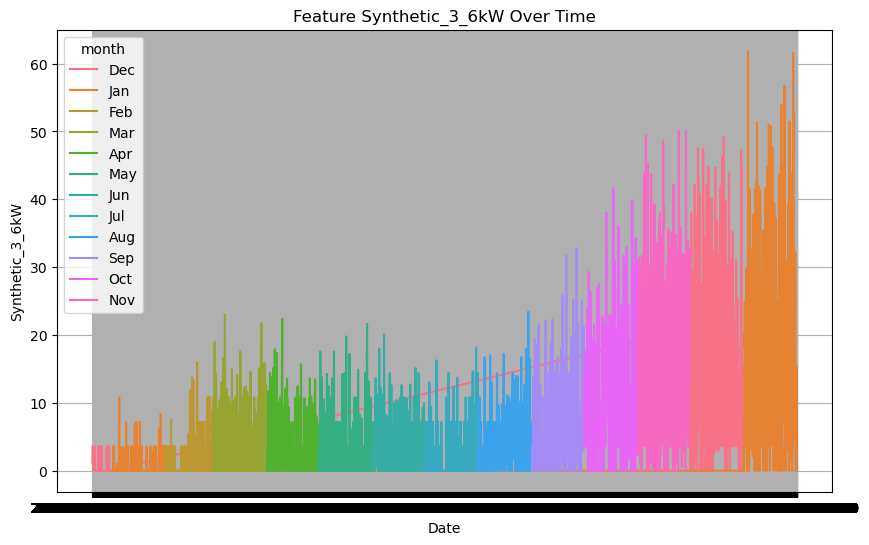

In [22]:

plt.figure(figsize=(10, 6)) 
sns.lineplot(data=df3a, x='date_from', y='Synthetic_3_6kW', hue='month')
plt.title('Feature Synthetic_3_6kW Over Time')
plt.xlabel('Date')
plt.ylabel('Synthetic_3_6kW')
plt.grid(True)
plt.show()

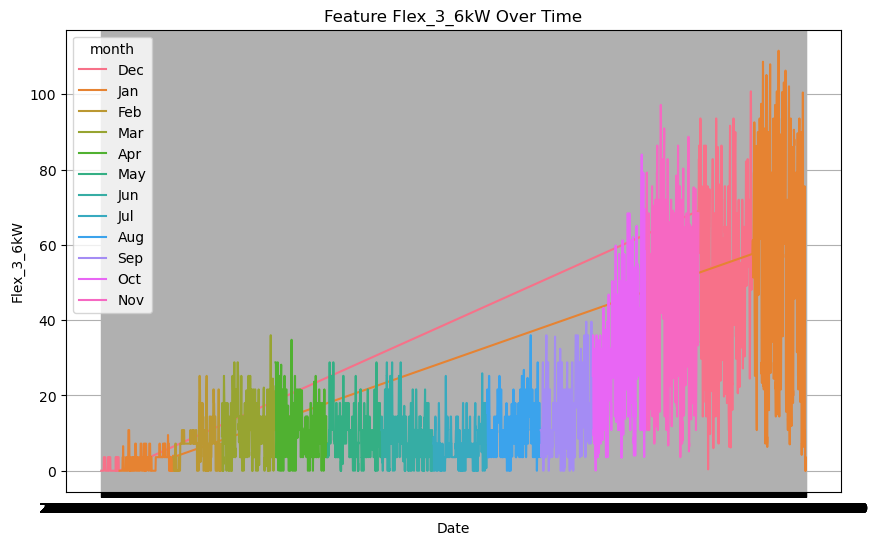

In [23]:


plt.figure(figsize=(10, 6))
sns.lineplot(data=df3a, x='date_from', y='Flex_3_6kW', hue='month')
plt.title('Feature Flex_3_6kW Over Time')
plt.xlabel('Date')
plt.ylabel('Flex_3_6kW')
plt.grid(True)
plt.show()

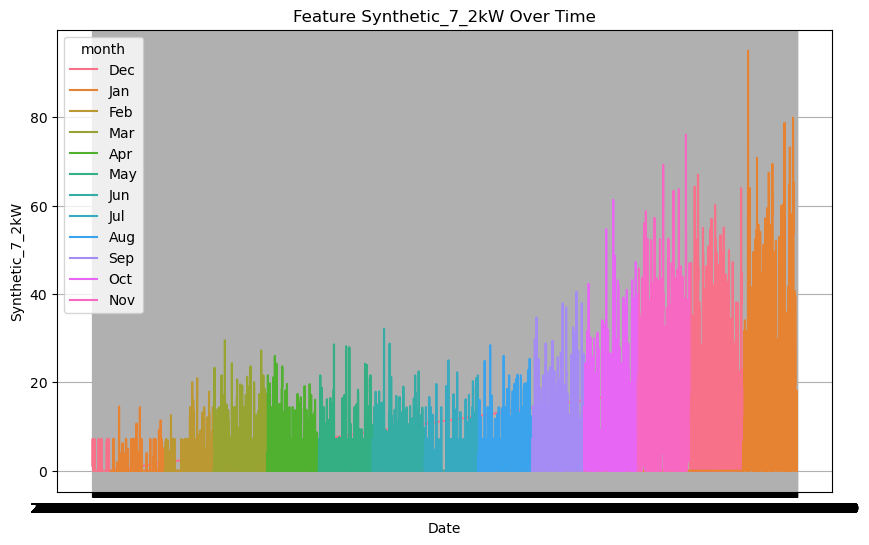

In [24]:


plt.figure(figsize=(10, 6))
sns.lineplot(data=df3a, x='date_from', y='Synthetic_7_2kW', hue='month')
plt.title('Feature Synthetic_7_2kW Over Time')
plt.xlabel('Date')
plt.ylabel('Synthetic_7_2kW')
plt.grid(True)
plt.show()

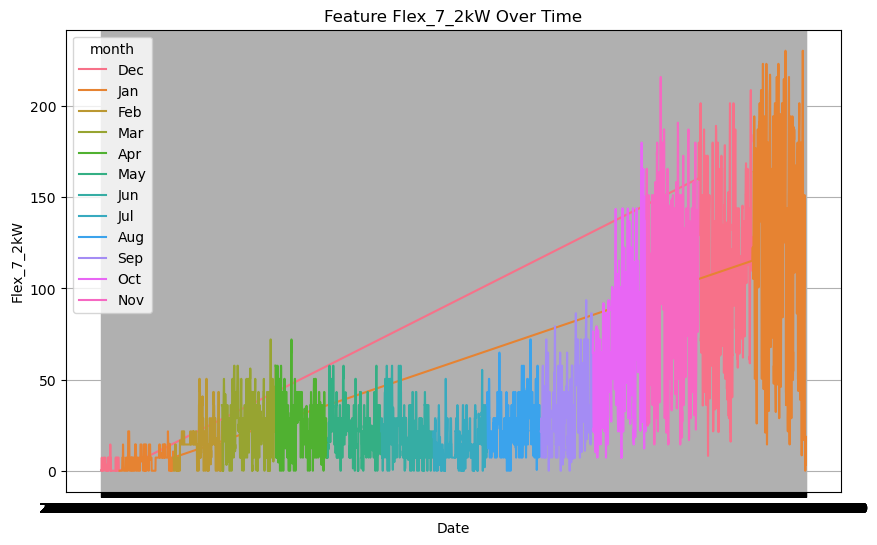

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df3a, x='date_from', y='Flex_7_2kW', hue='month')
plt.title('Feature Flex_7_2kW Over Time')
plt.xlabel('Date')
plt.ylabel('Flex_7_2kW')
plt.grid(True)
plt.show()

Synthetic feature names show energy load (kWh/h) and Flex feature names show idle capacity (kWh/h) for the aggregate or individual they represent. 

Therefore, the aggregate differential between idle capacity and active energy load utilized would provide an infrastructure normalized account of usage, which is seen to have an increasing capacity throughout the data collection timespan. A pertinent metric could be the percent of capacity utilized in relation to the traffic and weather observed during that time period. The ML model would seek to predict the usage percent based on the inputs of time, weather, traffic, and total available capacity as spaces and kW. 

Dataset 3 shows an aggregate reading of usage across time, grouped as private charging space or shared charging space. It shows tracking the hourly data for charging loads and idle capacity. This is a valuable net to look at for total demand across time in relation to weather and/or traffic. 

The resulting trends may be cross-referenced with traffic patterns and weather patterns. These subsequent features will be sourced for the given locality in Norway and joined based on the unique timestamp. The combined dataframe will then be applied to the ML model to forecast EV charging metrics. 

In [26]:

# vet percent capacity utilized
df3a['Total_3_6kW_capacity'] = df3a['Synthetic_3_6kW'] + df3a['Flex_3_6kW']
df3a['Total_7_2kW_capacity'] = df3a['Synthetic_7_2kW'] + df3a['Flex_7_2kW']


print(df3a.describe())

# df3a['utilized_3_6kW_capacity'] = df3a['Synthetic_3_6kW'] / ...max for dynamic time period? 
# the sum (synthetic + flex) does not seem to represent total capacity at time. 

# perhaps build aggregate data from individual records, df1: aggregate by 
#month_plugin 
#weekdays_plugin             
#Plugin_category

# sum for group: El_kWh, Duration_hours ~> then get the AVG kW for that time group. 
# note the duration is the space and El_kWh is the energy consumption, extrapolation (at 3.6kW? is the possible capacity)
# Plot / ML predict the AVG kW charge demand against the traffic+weather... 
# normalize the AVG kW for the demand staircase step up observed through the years course


# join number shared spot access, traffic, weather for time period; perform OLS statistics 

        daily_hour  Synthetic_3_6kW  Synthetic_7_2kW   Flex_3_6kW  \
count  9757.000000      9757.000000      9757.000000  9757.000000   
mean     11.505996         6.275547         6.274897    19.666952   
std       6.921223         8.974469        10.757467    22.225809   
min       0.000000         0.000000         0.000000     0.000000   
25%       6.000000         0.000000         0.000000     3.825000   
50%      12.000000         3.600000         0.000000    10.800000   
75%      18.000000         8.000000         7.200000    24.835000   
max      23.000000        61.890000        95.070000   111.600000   

        Flex_7_2kW    n_private  Total_3_6kW_capacity  Total_7_2kW_capacity  
count  9757.000000  9757.000000           9757.000000           9757.000000  
mean     45.083749    25.208876             25.942499             51.358646  
std      48.877288    16.971790             26.803070             53.203909  
min       0.000000     1.000000              0.000000             

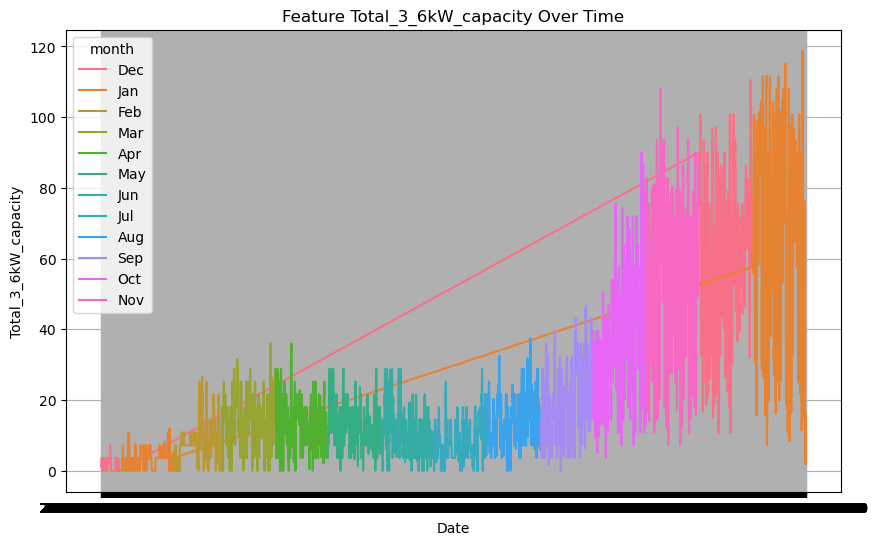

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df3a, x='date_from', y='Total_3_6kW_capacity', hue='month')
plt.title('Feature Total_3_6kW_capacity Over Time')
plt.xlabel('Date')
plt.ylabel('Total_3_6kW_capacity')
plt.grid(True)
plt.show()

In [27]:
df1['Date'] = pd.to_datetime(df1['Start_plugin'])
df1['Day_of_Month'] = df1['Date'].dt.day
print(df1)

      session_ID Garage_ID  User_ID User_type Shared_ID      Start_plugin  \
0              1      AdO3   AdO3-4   Private       NaN  21.12.2018 10:20   
1              2      AdO3   AdO3-4   Private       NaN  21.12.2018 10:24   
2              3      AdO3   AdO3-4   Private       NaN  21.12.2018 11:33   
3              4      AdO3   AdO3-2   Private       NaN  22.12.2018 16:15   
4              5      AdO3   AdO3-2   Private       NaN  24.12.2018 22:03   
...          ...       ...      ...       ...       ...               ...   
6873        6874      UT15   UT15-2   Private       NaN  31.01.2020 17:57   
6874        6875     AsO10  AsO10-1   Private       NaN  31.01.2020 18:32   
6875        6876       Bl2    Bl2-1   Private       NaN  31.01.2020 19:25   
6876        6877       UT7    UT7-1   Private       NaN  31.01.2020 19:27   
6877        6878       Bl2  Share-7    Shared  Shared-7  31.01.2020 20:42   

      Start_plugin_hour       End_plugout  End_plugout_hour El_kWh  \
0    

In [28]:
df1['El_kWh'] = df1['El_kWh'].str.replace(',', '.')
df1['El_kWh'] = pd.to_numeric(df1['El_kWh'], errors='coerce')

df1['Duration_hours'] = df1['Duration_hours'].str.replace(',', '.')
df1['Duration_hours'] = pd.to_numeric(df1['Duration_hours'], errors='coerce')

print(df1.info())
print(df1.head(10))
df1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   object        
 4   Shared_ID          1412 non-null   object        
 5   Start_plugin       6878 non-null   object        
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   object        
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  Plugin_category    6878 non-null   object        
 14  Duration

session_ID Garage_ID  User_ID User_type Shared_ID      Start_plugin  \
0              1      AdO3   AdO3-4   Private       NaN  21.12.2018 10:20   
1              2      AdO3   AdO3-4   Private       NaN  21.12.2018 10:24   
2              3      AdO3   AdO3-4   Private       NaN  21.12.2018 11:33   
3              4      AdO3   AdO3-2   Private       NaN  22.12.2018 16:15   
4              5      AdO3   AdO3-2   Private       NaN  24.12.2018 22:03   
...          ...       ...      ...       ...       ...               ...   
6873        6874      UT15   UT15-2   Private       NaN  31.01.2020 17:57   
6874        6875     AsO10  AsO10-1   Private       NaN  31.01.2020 18:32   
6875        6876       Bl2    Bl2-1   Private       NaN  31.01.2020 19:25   
6876        6877       UT7    UT7-1   Private       NaN  31.01.2020 19:27   
6877        6878       Bl2  Share-7    Shared  Shared-7  31.01.2020 20:42   

      Start_plugin_hour       End_plugout  End_plugout_hour  El_kWh  \
0                    10  21.12.2018 10:23              10.0    0.30   
1                    10  21.12.2018 10:32              10.0    0.87   
2                    11  21.12.2018 19:46              19.0   29.87   
3                    16  23.12.2018 16:40              16.0   15.56   
4                    22  24.12.2018 23:02              23.0    3.62   
...                 ...               ...               ...     ...   
6873                 17  31.01.2020 22:29              22.0   13.43   
6874                 18  31.01.2020 21:43              21.0    9.10   
6875                 19  31.01.2020 20:37              20.0    4.28   
6876                 19  31.01.2020 19:48              19.0    2.31   
6877                 20  31.01.2020 23:53              23.0   20.14   

      Duration_hours month_plugin weekdays_plugin             Plugin_category  \
0           0.050000          Dec          Friday         late morning (9-12)   
1           0.136667          Dec          Friday         late morning (9-12)   
2           8.216389          Dec          Friday         late morning (9-12)   
3          24.419722          Dec        Saturday      late afternoon (15-18)   
4           0.970556          Dec          Monday  late evening (21-midnight)   
...              ...          ...             ...                         ...   
6873        4.530000          Jan          Friday      late afternoon (15-18)   
6874        3.182222          Jan          Friday       early evening (18-21)   
6875        1.203889          Jan          Friday       early evening (18-21)   
6876        0.352500          Jan          Friday       early evening (18-21)   
6877        3.184167          Jan          Friday       early evening (18-21)   

           Duration_category                Date  Day_of_Month  
0          Less than 3 hours 2018-12-21 10:20:00            21  
1          Less than 3 hours 2018-12-21 10:24:00            21  
2     Between 6 and 9  hours 2018-12-21 11:33:00            21  
3         More than 18 hours 2018-12-22 16:15:00            22  
4          Less than 3 hours 2018-12-24 22:03:00            24  
...                      ...                 ...           ...  
6873   Between 3 and 6 hours 2020-01-31 17:57:00            31  
6874   Between 3 and 6 hours 2020-01-31 18:32:00            31  
6875       Less than 3 hours 2020-01-31 19:25:00            31  
6876       Less than 3 hours 2020-01-31 19:27:00            31  
6877   Between 3 and 6 hours 2020-01-31 20:42:00            31  

[6878 rows x 17 columns]

In [30]:

# group DF1 by 3-hour per-day time window, aggregate features including sum, avg, count

grouped_df1 = df1.groupby(['month_plugin', 'Day_of_Month', 'weekdays_plugin', 'Plugin_category']).agg(
    net_El_kWh=('El_kWh', 'sum'),
    net_Duration_hours=('Duration_hours', 'sum'),
    Date=('Date', 'mean'),
    count_shared=('Shared_ID', 'count'),
    count_users=('User_type', 'count')
    # add count Shared_ID, count User_type for all, then try to get % shared as diff
).reset_index()

grouped_df1['prct_shared_user'] = grouped_df1['count_shared'] / grouped_df1['count_users']

grouped_df1['Month_Number'] = pd.to_datetime(grouped_df1['month_plugin'], format='%b').dt.month

grouped_df1['Plugin_category'] = grouped_df1['Plugin_category'].astype('category')

# Define the mapping dictionary for renaming categories
category_mapping = {
    'early evening (18-21)': '7) early evening (18-21)',
    'early morning (6-9)': '3) early morning (6-9)',
    'late afternoon (15-18)': '6) late afternoon (15-18)',
    'late evening (21-midnight)': '8) late evening (21-midnight)',
    'late morning (9-12)': '4) late morning (9-12)',
    'early afternoon (12-15)': '5) early afternoon (12-15)',
    'early night (midnight-3)': '1) early night (midnight-3)',
    'late night (3-6)': '2) late night (3-6)'
}

grouped_df1['Plugin_category'] = grouped_df1['Plugin_category'].cat.rename_categories(category_mapping)

print("\nGrouped DataFrame1 by month day category, sum El_kWh:")
# print(grouped_df1)
print(grouped_df1.describe())


Grouped DataFrame1 by month day category, sum El_kWh:
     month_plugin  Day_of_Month weekdays_plugin  \
0             Apr             1          Monday   
1             Apr             1          Monday   
2             Apr             1          Monday   
3             Apr             1          Monday   
4             Apr             1          Monday   
...           ...           ...             ...   
1812          Sep            30          Monday   
1813          Sep            30          Monday   
1814          Sep            30          Monday   
1815          Sep            30          Monday   
1816          Sep            30          Monday   

                    Plugin_category  net_El_kWh  net_Duration_hours  \
0          7) early evening (18-21)       26.38           27.011111   
1            3) early morning (6-9)       25.43            3.627500   
2         6) late afternoon (15-18)       44.17           32.930278   
3     8) late evening (21-midnight)       55.79 

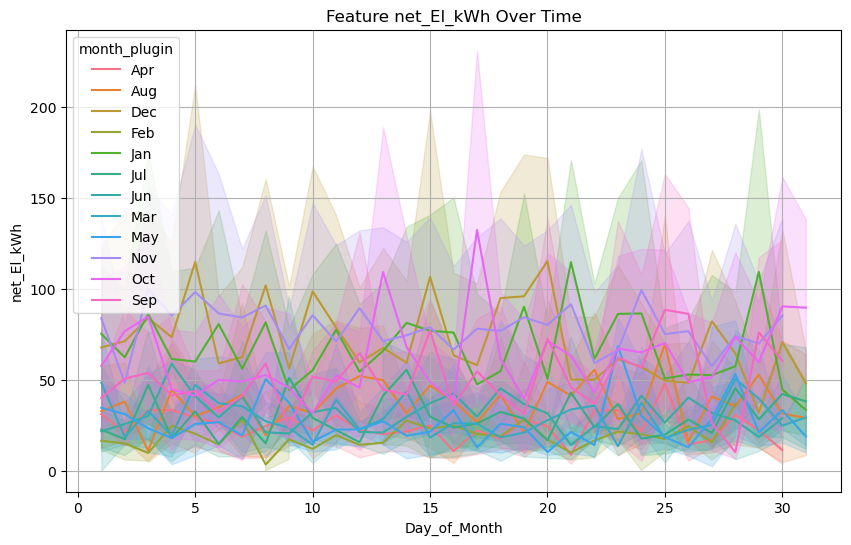

In [31]:
# plot grouped_df1 El_kWh by day of month
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df1, x='Day_of_Month', y='net_El_kWh', hue='month_plugin')
plt.title('Feature net_El_kWh Over Time')
plt.xlabel('Day_of_Month')
plt.ylabel('net_El_kWh')
plt.grid(True)
plt.show()

In [32]:
#sort drouped DF by category for plot
sorted_categories = sorted(grouped_df1['Plugin_category'].unique())
grouped_df1['Plugin_category'] = grouped_df1['Plugin_category'].cat.set_categories(sorted_categories, ordered=True)
grouped_df1_sorted_cat = grouped_df1.sort_values('Plugin_category')

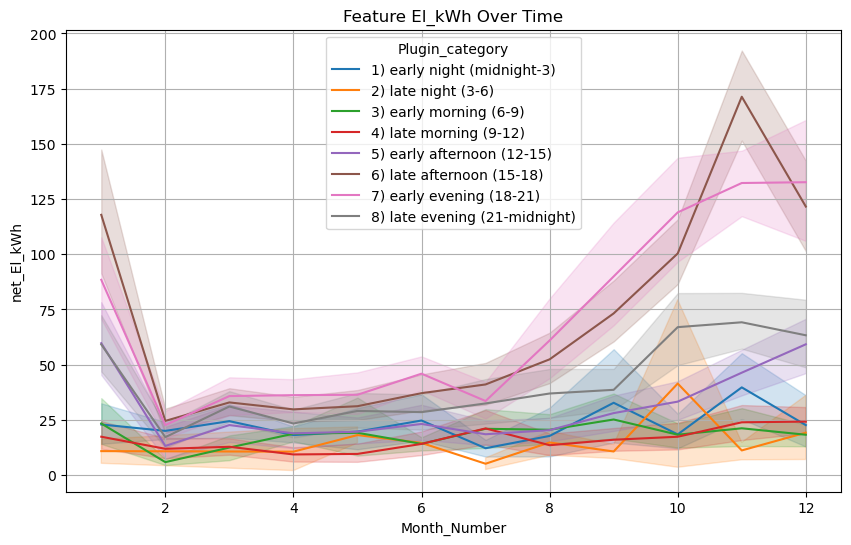

In [33]:
# plot grouped_df1 El_kWh

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df1_sorted_cat, x='Month_Number', y='net_El_kWh', hue='Plugin_category')
plt.title('Feature El_kWh Over Time')
plt.xlabel('Month_Number')
plt.ylabel('net_El_kWh')
plt.grid(True)
plt.show()

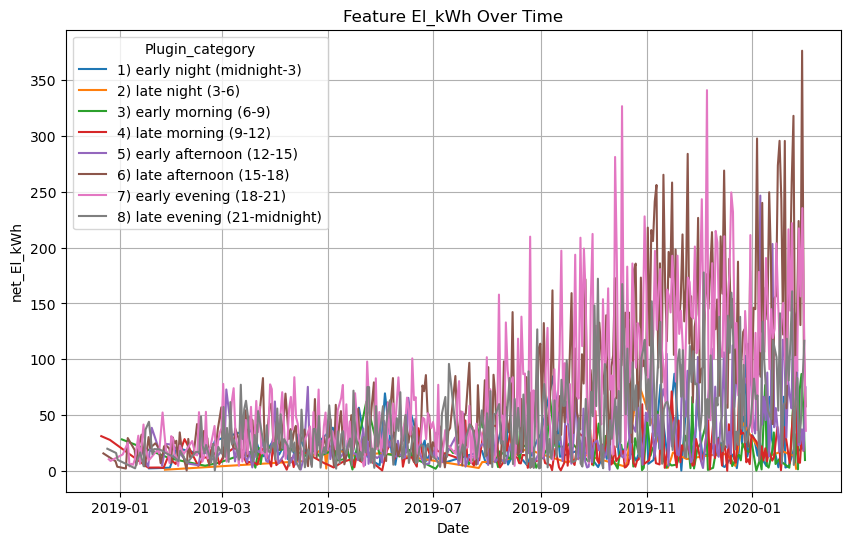

In [34]:
# by Date
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df1_sorted_cat, x='Date', y='net_El_kWh', hue='Plugin_category')
plt.title('Feature El_kWh Over Time')
plt.xlabel('Date')
plt.ylabel('net_El_kWh')
plt.grid(True)
plt.show()

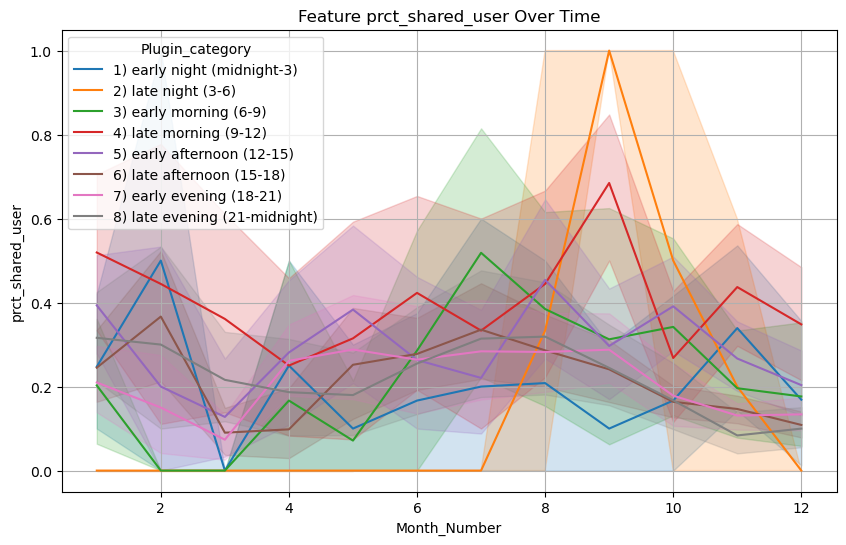

In [35]:
# prct_shared_user as the percent of users that are public by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df1_sorted_cat, x='Month_Number', y='prct_shared_user', hue='Plugin_category')
plt.title('Feature prct_shared_user Over Time')
plt.xlabel('Month_Number')
plt.ylabel('prct_shared_user')
plt.grid(True)
plt.show()

In [37]:
date_grouped_df1 = df1.groupby(['Date', 'Plugin_category'])['El_kWh'].sum().reset_index()
print("\nGrouped DataFrame1 by month day category, sum El_kWh:")
print(date_grouped_df1)
print(date_grouped_df1.describe())


Grouped DataFrame1 by month day category, sum El_kWh:
                    Date             Plugin_category  El_kWh
0    2018-12-21 10:20:00         late morning (9-12)    0.30
1    2018-12-21 10:24:00         late morning (9-12)    0.87
2    2018-12-21 11:33:00         late morning (9-12)   29.87
3    2018-12-22 16:15:00      late afternoon (15-18)   15.56
4    2018-12-24 22:03:00  late evening (21-midnight)    3.62
...                  ...                         ...     ...
6735 2020-01-31 17:57:00      late afternoon (15-18)   13.43
6736 2020-01-31 18:32:00       early evening (18-21)    9.10
6737 2020-01-31 19:25:00       early evening (18-21)    4.28
6738 2020-01-31 19:27:00       early evening (18-21)    2.31
6739 2020-01-31 20:42:00       early evening (18-21)   20.14

[6740 rows x 3 columns]
                                Date       El_kWh
count                           6740  6740.000000
mean   2019-09-30 14:03:50.759643904    12.981199
min              2018-12-21 10:20:00  

In [39]:
print(df6.head(10))

          Date_from           Date_to KROPPAN BRU MOHOLTLIA SELSBAKK  \
0  01.12.2018 00:00  01.12.2018 01:00         639         0        0   
1  01.12.2018 01:00  01.12.2018 02:00         487       153      115   
2  01.12.2018 02:00  01.12.2018 03:00         408        85       75   
3  01.12.2018 03:00  01.12.2018 04:00         282        89       56   
4  01.12.2018 04:00  01.12.2018 05:00         165        64       34   
5  01.12.2018 05:00  01.12.2018 06:00         169        78       37   
6  01.12.2018 06:00  01.12.2018 07:00         277       148       60   
7  01.12.2018 07:00  01.12.2018 08:00         558       359       93   
8  01.12.2018 08:00  01.12.2018 09:00         783       481      141   
9  01.12.2018 09:00  01.12.2018 10:00        1239       686      201   

   MOHOLT RAMPE 2  Jonsvannsveien vest for Steinanvegen  
0               4                                   144  
1              21                                    83  
2              10                

In [40]:
df6['KROPPAN BRU'] = pd.to_numeric(df6['KROPPAN BRU'], errors='coerce')
df6['MOHOLTLIA'] = pd.to_numeric(df6['MOHOLTLIA'], errors='coerce')
df6['SELSBAKK'] = pd.to_numeric(df6['SELSBAKK'], errors='coerce')
df6['MOHOLT RAMPE 2'] = pd.to_numeric(df6['MOHOLT RAMPE 2'], errors='coerce')
df6['Jonsvannsveien vest for Steinanvegen'] = pd.to_numeric(df6['Jonsvannsveien vest for Steinanvegen'], errors='coerce')
print(df6.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date_from                             10248 non-null  object 
 1   Date_to                               10248 non-null  object 
 2   KROPPAN BRU                           10246 non-null  float64
 3   MOHOLTLIA                             10247 non-null  float64
 4   SELSBAKK                              10246 non-null  float64
 5   MOHOLT RAMPE 2                        10248 non-null  int64  
 6   Jonsvannsveien vest for Steinanvegen  10248 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 560.6+ KB
None


In [41]:
df6['5_point_traffic_avg'] = df6['KROPPAN BRU'] + df6['MOHOLTLIA'] + df6['SELSBAKK'] + df6['MOHOLT RAMPE 2'] + df6['Jonsvannsveien vest for Steinanvegen']
df6['5_point_traffic_avg'] = df6['5_point_traffic_avg'] / 5

# group timestamps per category_mapping time window, per day ~ join on the grouped df1

# df1['Date'] = pd.to_datetime(df1['Start_plugin'])
# df1['Day_of_Month'] = df1['Date'].dt.day
# df1.groupby(['month_plugin', 'Day_of_Month', 'weekdays_plugin', 'Plugin_category']
df6['Date'] = pd.to_datetime(df6['Date_from'], format='%d.%m.%Y %H:%M')
df6['Day_of_Month'] = df6['Date'].dt.day
df6['month_plugin'] = df6['Date'].dt.strftime('%b')

df6['t_start_hour'] = pd.to_datetime(df6['Date_from'], format='%d.%m.%Y %H:%M').dt.hour
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
labels = [
    '1) early night (midnight-3)',
    '2) late night (3-6)',
    '3) early morning (6-9)',
    '4) late morning (9-12)',
    '5) early afternoon (12-15)',
    '6) late afternoon (15-18)',
    '7) early evening (18-21)',
    '8) late evening (21-midnight)'
]

df6['Plugin_category'] = pd.cut(
    df6['t_start_hour'],
    bins=bins,
    labels=labels,
    right=False
)

print("DataFrame with new time bins:")
print(df6.head(10))
print("\nCount of values per time bin:")
print(df6['Plugin_category'].value_counts().sort_index())

print(df6.describe())

DataFrame with new time bins:
          Date_from           Date_to  KROPPAN BRU  MOHOLTLIA  SELSBAKK  \
0  01.12.2018 00:00  01.12.2018 01:00        639.0        0.0       0.0   
1  01.12.2018 01:00  01.12.2018 02:00        487.0      153.0     115.0   
2  01.12.2018 02:00  01.12.2018 03:00        408.0       85.0      75.0   
3  01.12.2018 03:00  01.12.2018 04:00        282.0       89.0      56.0   
4  01.12.2018 04:00  01.12.2018 05:00        165.0       64.0      34.0   
5  01.12.2018 05:00  01.12.2018 06:00        169.0       78.0      37.0   
6  01.12.2018 06:00  01.12.2018 07:00        277.0      148.0      60.0   
7  01.12.2018 07:00  01.12.2018 08:00        558.0      359.0      93.0   
8  01.12.2018 08:00  01.12.2018 09:00        783.0      481.0     141.0   
9  01.12.2018 09:00  01.12.2018 10:00       1239.0      686.0     201.0   

   MOHOLT RAMPE 2  Jonsvannsveien vest for Steinanvegen  5_point_traffic_avg  \
0               4                                   144         

In [42]:
# merge df6 grouped on df1 grouped: groupby(['month_plugin', 'Day_of_Month', 'Plugin_category']
# df6['5_point_traffic_avg'] = df6['KROPPAN BRU'] + df6['MOHOLTLIA'] + df6['SELSBAKK'] + df6['MOHOLT RAMPE 2'] + df6['Jonsvannsveien vest for Steinanvegen']

grouped_df6 = df6.groupby(['month_plugin', 'Day_of_Month', 'Plugin_category']).agg(
    P_c_avg_5_point_traffic_avg=('5_point_traffic_avg', 'mean'),
    P_c_avg_KROPPAN_BRU=('KROPPAN BRU', 'mean'),
    P_c_avg_MOHOLTLIA=('MOHOLTLIA', 'mean'),
    P_c_avg_SELSBAKK=('SELSBAKK', 'mean'),
    P_c_avg_MOHOLT_RAMPE_2=('MOHOLT RAMPE 2', 'mean'),
    P_c_avg_Jonsvannsveien=('Jonsvannsveien vest for Steinanvegen', 'mean'),
).reset_index()

print(grouped_df6.head())
print(grouped_df6.describe())

  month_plugin  Day_of_Month              Plugin_category  \
0          Apr             1  1) early night (midnight-3)   
1          Apr             1          2) late night (3-6)   
2          Apr             1       3) early morning (6-9)   
3          Apr             1       4) late morning (9-12)   
4          Apr             1   5) early afternoon (12-15)   

   P_c_avg_5_point_traffic_avg  P_c_avg_KROPPAN_BRU  P_c_avg_MOHOLTLIA  \
0                    51.200000           126.000000          61.333333   
1                   115.733333           304.333333         175.000000   
2                  1457.000000          3819.333333        2016.333333   
3                   942.000000          2450.333333        1216.333333   
4                  1111.133333          2932.333333        1397.333333   

   P_c_avg_SELSBAKK  P_c_avg_MOHOLT_RAMPE_2  P_c_avg_Jonsvannsveien  
0         28.666667               10.333333               29.666667  
1         43.666667                6.333333     

In [43]:
# sorted grouped df1: grouped_df1_sorted_cat ~ merge grouped df6
merged_df = pd.merge(grouped_df1_sorted_cat, grouped_df6, on=['month_plugin', 'Day_of_Month', 'Plugin_category'], how='left')

print(merged_df)

     month_plugin  Day_of_Month weekdays_plugin  \
0             Nov            10          Sunday   
1             Jan             5          Sunday   
2             Nov            30        Saturday   
3             Jun            24          Monday   
4             Nov            29          Friday   
...           ...           ...             ...   
1812          Oct            13          Sunday   
1813          Mar            16        Saturday   
1814          Dec             5        Thursday   
1815          Apr            20        Saturday   
1816          Aug            22        Thursday   

                    Plugin_category  net_El_kWh  net_Duration_hours  \
0       1) early night (midnight-3)       50.16           18.883056   
1       1) early night (midnight-3)       28.75           12.417500   
2       1) early night (midnight-3)       64.02           29.413056   
3       1) early night (midnight-3)       19.68           11.869722   
4       1) early night (midnight

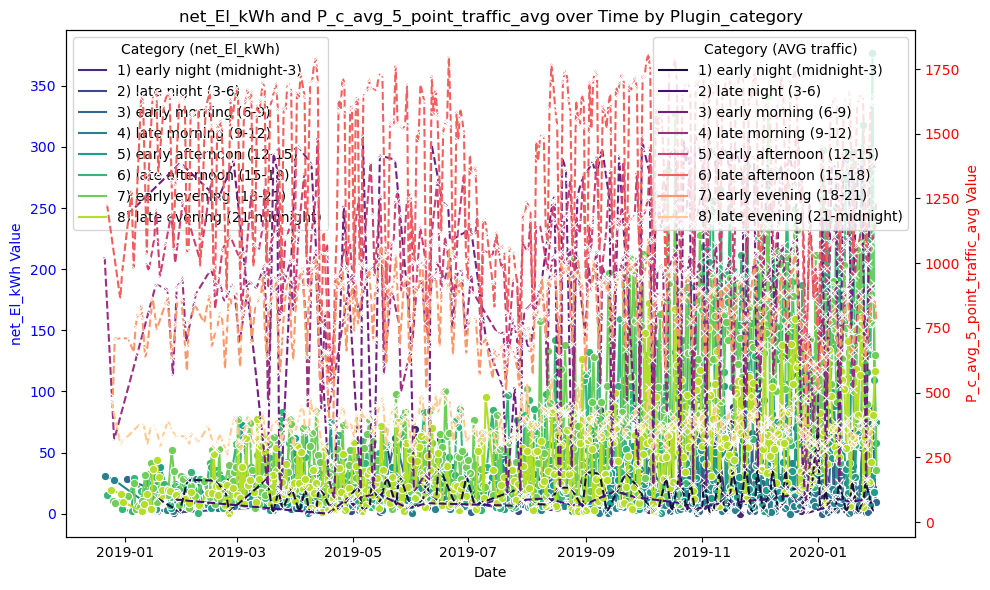

In [44]:
df = merged_df

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

sns.lineplot(data=df, x='Date', y='net_El_kWh', hue='Plugin_category', ax=ax1, marker='o', palette='viridis')
ax1.set_ylabel('net_El_kWh Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

sns.lineplot(data=df, x='Date', y='P_c_avg_5_point_traffic_avg', hue='Plugin_category', ax=ax2, marker='x', linestyle='--', palette='magma')
ax2.set_ylabel('P_c_avg_5_point_traffic_avg Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Date')
plt.title('net_El_kWh and P_c_avg_5_point_traffic_avg over Time by Plugin_category')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1, labels=labels1, title='Category (net_El_kWh)', loc='upper left')
ax2.legend(handles=handles2, labels=labels2, title='Category (AVG traffic)', loc='upper right')


plt.tight_layout()
plt.show()

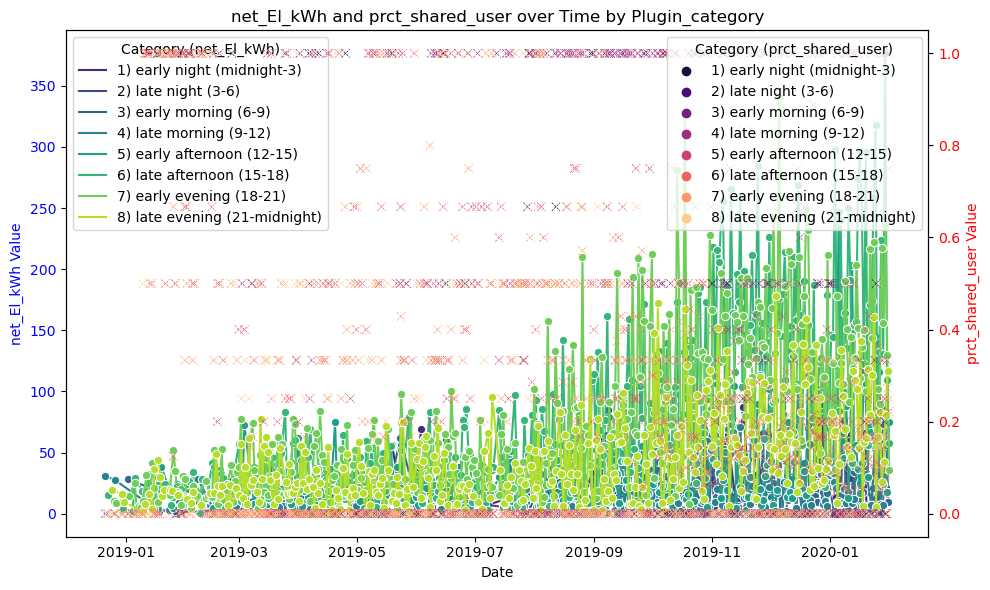

In [45]:
df = merged_df

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

sns.lineplot(data=df, x='Date', y='net_El_kWh', hue='Plugin_category', ax=ax1, marker='o', palette='viridis')
ax1.set_ylabel('net_El_kWh Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

sns.scatterplot(data=df, x='Date', y='prct_shared_user', hue='Plugin_category', ax=ax2, marker='x', linestyle='--', palette='magma')
ax2.set_ylabel('prct_shared_user Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Date')
plt.title('net_El_kWh and prct_shared_user over Time by Plugin_category')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1, labels=labels1, title='Category (net_El_kWh)', loc='upper left')
ax2.legend(handles=handles2, labels=labels2, title='Category (prct_shared_user)', loc='upper right')


plt.tight_layout()
plt.show()

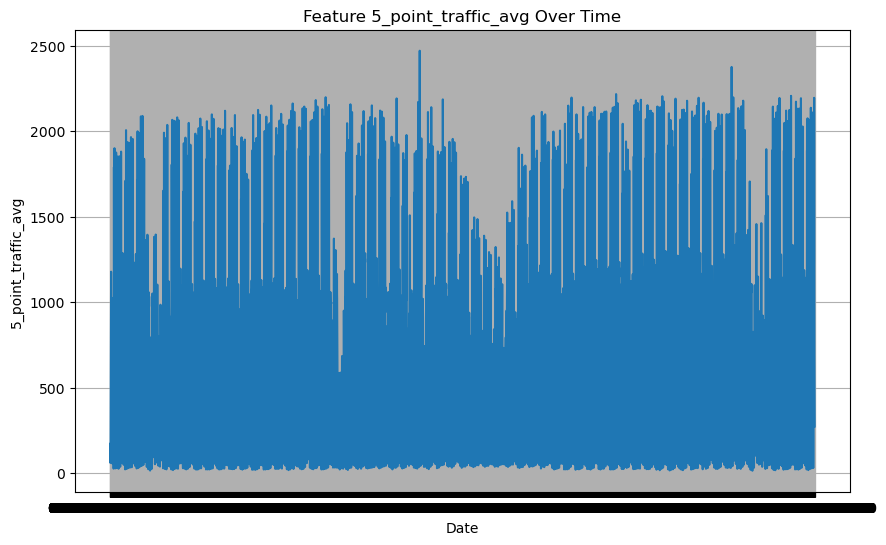

In [46]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df6, x='Date_from', y='5_point_traffic_avg')
plt.title('Feature 5_point_traffic_avg Over Time')
plt.xlabel('Date')
plt.ylabel('5_point_traffic_avg')
plt.grid(True)
plt.show()

In [47]:
import statsmodels.formula.api as smf
model = smf.ols(formula='net_El_kWh ~ Plugin_category + P_c_avg_5_point_traffic_avg + prct_shared_user', data=merged_df)

model = model.fit()

print(model.summary())

# poor correlation; net_El_kWh needs to be normalized for staircase step up in capacity over year;
# implement newly engineered feature percent_utilization_net as net_El_kWh / period_max_capacity_est
# manually source and compute the period_max_capacity_est, then merge into the grouped df 

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     50.09
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           2.77e-81
Time:                        16:39:26   Log-Likelihood:                -9576.6
No. Observations:                1817   AIC:                         1.917e+04
Df Residuals:                    1807   BIC:                         1.923e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [48]:
model = smf.ols(formula='net_El_kWh ~ P_c_avg_5_point_traffic_avg', data=merged_df)

model = model.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     88.52
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           1.47e-20
Time:                        16:40:10   Log-Likelihood:                -9735.7
No. Observations:                1817   AIC:                         1.948e+04
Df Residuals:                    1815   BIC:                         1.949e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [49]:

model = smf.ols(formula='prct_shared_user ~ Plugin_category', data=merged_df)

model = model.fit()

print(model.summary())
# we see the percent of users that are not private has a higher correlation to the time being between 9 and 15:00 hours.
# this seems plausible, as private residents are likely to be away during these times, so users are more likely to be pulic, i.e. "shared"

                            OLS Regression Results                            
Dep. Variable:       prct_shared_user   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     11.35
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           3.80e-14
Time:                        16:40:27   Log-Likelihood:                -539.39
No. Observations:                1817   AIC:                             1095.
Df Residuals:                    1809   BIC:                             1139.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [50]:
# P_c_avg_5_point_traffic_avg by time category 

model = smf.ols(formula='P_c_avg_5_point_traffic_avg ~ Plugin_category', data=merged_df)

model = model.fit()

print(model.summary())
# traffic is highly correlated to the 3 hour time window of day, throughout the year, with the anomaly exception 3am to 6am

                                 OLS Regression Results                                
Dep. Variable:     P_c_avg_5_point_traffic_avg   R-squared:                       0.756
Model:                                     OLS   Adj. R-squared:                  0.756
Method:                          Least Squares   F-statistic:                     802.8
Date:                         Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                                 16:40:49   Log-Likelihood:                -12448.
No. Observations:                         1817   AIC:                         2.491e+04
Df Residuals:                             1809   BIC:                         2.496e+04
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---

### Normalize target feature net_El_kWh to the general monthly benchmark


In [51]:

# poor correlation; net_El_kWh needs to be normalized for staircase step up in capacity over year;
# implement newly engineered feature percent_utilization_net as net_El_kWh / period_max_capacity_est
# manually source and compute the period_max_capacity_est, then merge into the grouped df 

# merged_df

# df3a
grouped_df3a = df3a.groupby(['month']).agg(
    Synthetic_3_6kW_avg=('Synthetic_3_6kW', 'mean'),
    Synthetic_3_6kW_sum=('Synthetic_3_6kW', 'sum'),
    Synthetic_7_2kW_avg=('Synthetic_7_2kW', 'mean'),
    Flex_3_6kW_avg=('Flex_3_6kW', 'mean'),
    Flex_7_2kW_avg=('Flex_7_2kW', 'mean'),
    Total_3_6kW_capacity_avg=('Total_3_6kW_capacity', 'mean'),
    Total_3_6kW_capacity_max=('Total_3_6kW_capacity', 'max'),
    Total_7_2kW_capacity_avg=('Total_7_2kW_capacity', 'mean'),
    Total_7_2kW_capacity_max=('Total_7_2kW_capacity', 'max'),
).reset_index()

grouped_df3a

month  Synthetic_3_6kW_avg  Synthetic_3_6kW_sum  Synthetic_7_2kW_avg  \
0    Apr             3.288458              2367.69             3.288458   
1    Aug             3.900645              2902.08             3.897097   
2    Dec            10.650481             10629.18            10.586643   
3    Feb             1.492202              1002.76             1.515074   
4    Jan             8.321997             12374.81             8.321997   
5    Jul             2.440269              1815.56             2.416640   
6    Jun             3.214722              2314.60             3.239556   
7    Mar             3.822328              2839.99             3.801642   
8    May             3.095847              2303.31             3.098992   
9    Nov            14.474903             10421.93            14.505569   
10   Oct            10.340671              7703.80            10.353812   
11   Sep             6.326111              4554.80             6.361528   

    Flex_3_6kW_avg  Flex_7_2kW_avg  Total_3_6kW_capacity_avg  \
0        10.858247       24.954003                 14.146706   
1        11.181051       26.134210                 15.081696   
2        37.129291       83.460697                 47.779772   
3         7.094558       15.657979                  8.586760   
4        28.905879       65.360299                 37.227876   
5         6.630855       15.667035                  9.071124   
6         9.006404       21.082017                 12.221126   
7        11.334608       26.481930                 15.156937   
8        10.021637       23.084390                 13.117484   
9        43.232497       99.772442                 57.707400   
10       29.661026       68.438644                 40.001697   
11       14.482854       34.660508                 20.808965   

    Total_3_6kW_capacity_max  Total_7_2kW_capacity_avg  \
0                     36.000                 28.242461   
1                     37.445                 30.031306   
2                    110.520                 94.047341   
3                     26.660                 17.173054   
4                    118.800                 73.682296   
5                     28.800                 18.083675   
6                     28.800                 24.321572   
7                     36.000                 30.283572   
8                     28.800                 26.183382   
9                    108.000                114.278011   
10                    90.000                 78.792456   
11                    46.800                 41.022036   

    Total_7_2kW_capacity_max  
0                     72.000  
1                     81.830  
2                    210.370  
3                     56.294  
4                    241.280  
5                     57.600  
6                     57.600  
7                     72.000  
8                     57.600  
9                    216.000  
10                   180.000  
11                    93.600

In [52]:
grouped_df3a = grouped_df3a.rename(columns={'month': 'month_plugin'})


In [53]:
# merge monthly Total_3_6kW_capacity_avg and Total_7_2kW_capacity_avg
merged_df_month_caps = pd.merge(merged_df, grouped_df3a, on=['month_plugin'], how='left')

#  percent_utilization_net as net_El_kWh / period_max_capacity_est
# manually source and compute the period_max_capacity_est, as Total_3_6kW_capacity_avg,  Total_7_2kW_capacity_avg

merged_df_month_caps['percent_utilization_net_3_6kW'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_3_6kW_capacity_avg'])

merged_df_month_caps['percent_utilization_net_7_2kW'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_7_2kW_capacity_avg'])

merged_df_month_caps['percent_utilization_net_3_6kW_max'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_3_6kW_capacity_max'])

merged_df_month_caps['percent_utilization_net_7_2kW_max'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_7_2kW_capacity_max'])


print(merged_df_month_caps)
print(merged_df_month_caps.describe())

     month_plugin  Day_of_Month weekdays_plugin  \
0             Nov            10          Sunday   
1             Jan             5          Sunday   
2             Nov            30        Saturday   
3             Jun            24          Monday   
4             Nov            29          Friday   
...           ...           ...             ...   
1812          Oct            13          Sunday   
1813          Mar            16        Saturday   
1814          Dec             5        Thursday   
1815          Apr            20        Saturday   
1816          Aug            22        Thursday   

                    Plugin_category  net_El_kWh  net_Duration_hours  \
0       1) early night (midnight-3)       50.16           18.883056   
1       1) early night (midnight-3)       28.75           12.417500   
2       1) early night (midnight-3)       64.02           29.413056   
3       1) early night (midnight-3)       19.68           11.869722   
4       1) early night (midnight

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_feature = scaler.fit_transform(merged_df_month_caps[['percent_utilization_net_7_2kW_max']])

merged_df_month_caps['scaled_percent_utilization_net_7_2kW_max'] = scaled_feature


binned_data_cut = pd.cut(merged_df_month_caps['scaled_percent_utilization_net_7_2kW_max'], bins=4, labels=False) 
print("Equal-width bins (pd.cut):")
print(binned_data_cut.value_counts().sort_index())
print(binned_data_cut)

merged_df_month_caps['utilization_4_bins'] = binned_data_cut

Equal-width bins (pd.cut):
scaled_percent_utilization_net_7_2kW_max
0    1449
1     322
2      39
3       7
Name: count, dtype: int64
0       0
1       0
2       0
3       0
4       0
       ..
1812    0
1813    0
1814    0
1815    0
1816    0
Name: scaled_percent_utilization_net_7_2kW_max, Length: 1817, dtype: int64


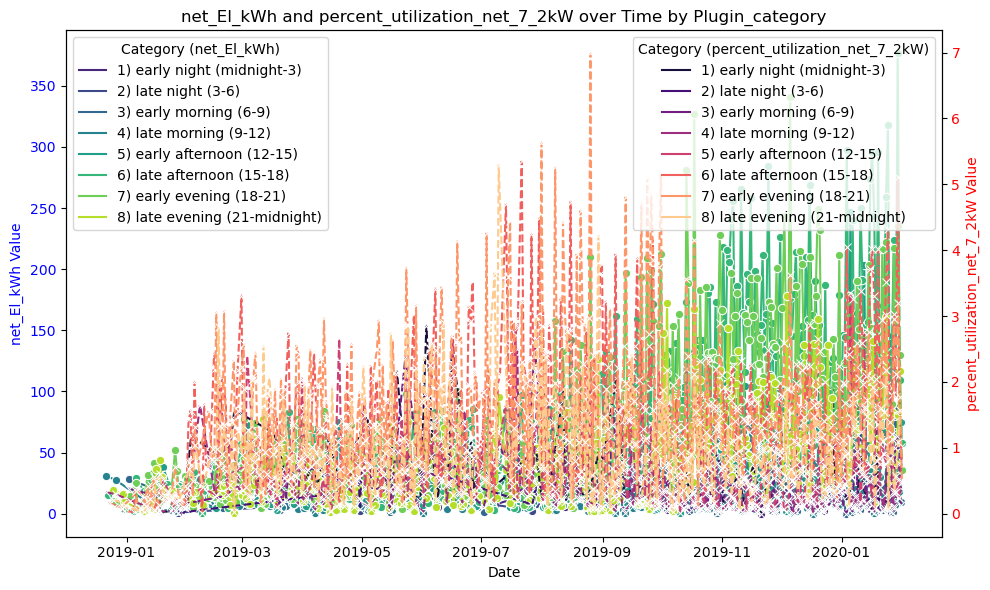

In [55]:
df = merged_df_month_caps

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

sns.lineplot(data=df, x='Date', y='net_El_kWh', hue='Plugin_category', ax=ax1, marker='o', palette='viridis')
ax1.set_ylabel('net_El_kWh Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

sns.lineplot(data=df, x='Date', y='percent_utilization_net_7_2kW', hue='Plugin_category', ax=ax2, marker='x', linestyle='--', palette='magma')
ax2.set_ylabel('percent_utilization_net_7_2kW Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Date')
plt.title('net_El_kWh and percent_utilization_net_7_2kW over Time by Plugin_category')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1, labels=labels1, title='Category (net_El_kWh)', loc='upper left')
ax2.legend(handles=handles2, labels=labels2, title='Category (percent_utilization_net_7_2kW)', loc='upper right')


plt.tight_layout()
plt.show()

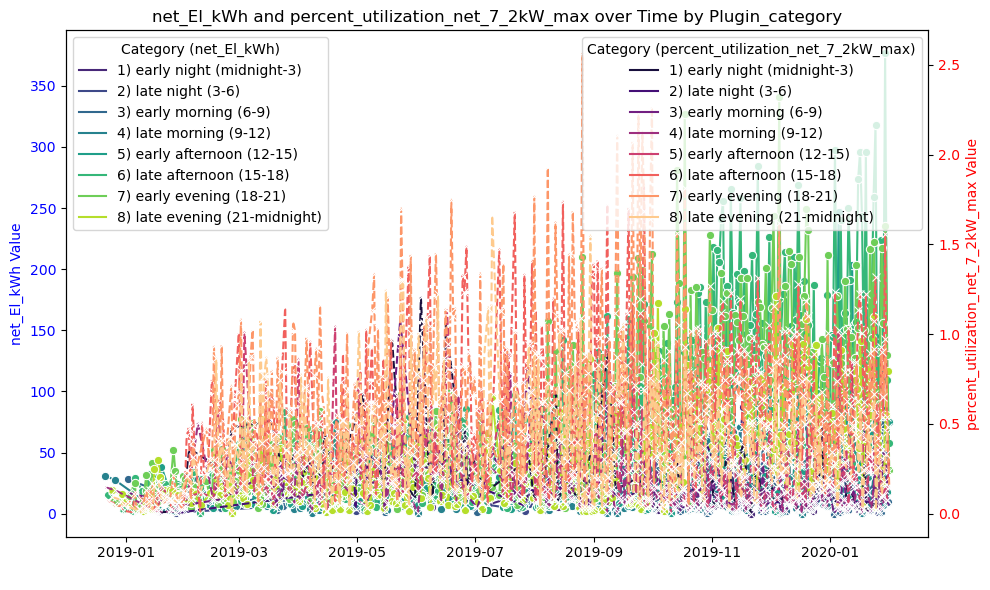

In [56]:
# percent_utilization_net_7_2kW_max

df = merged_df_month_caps

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

sns.lineplot(data=df, x='Date', y='net_El_kWh', hue='Plugin_category', ax=ax1, marker='o', palette='viridis')
ax1.set_ylabel('net_El_kWh Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

sns.lineplot(data=df, x='Date', y='percent_utilization_net_7_2kW_max', hue='Plugin_category', ax=ax2, marker='x', linestyle='--', palette='magma')
ax2.set_ylabel('percent_utilization_net_7_2kW_max Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Date')
plt.title('net_El_kWh and percent_utilization_net_7_2kW_max over Time by Plugin_category')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1, labels=labels1, title='Category (net_El_kWh)', loc='upper left')
ax2.legend(handles=handles2, labels=labels2, title='Category (percent_utilization_net_7_2kW_max)', loc='upper right')


plt.tight_layout()
plt.show()

In [57]:
#  P_c_avg_5_point_traffic_avg + prct_shared_user
# Plugin_category + month_plugin +  Day_of_Month + weekdays_plugin
model = smf.ols(formula='percent_utilization_net_7_2kW_max ~ P_c_avg_KROPPAN_BRU + P_c_avg_MOHOLTLIA + P_c_avg_SELSBAKK + P_c_avg_MOHOLT_RAMPE_2 + P_c_avg_Jonsvannsveien', data=merged_df_month_caps)

model = model.fit()

print(model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     percent_utilization_net_7_2kW_max   R-squared:                       0.177
Model:                                           OLS   Adj. R-squared:                  0.175
Method:                                Least Squares   F-statistic:                     78.11
Date:                               Fri, 26 Sep 2025   Prob (F-statistic):           2.47e-74
Time:                                       16:46:39   Log-Likelihood:                -518.15
No. Observations:                               1817   AIC:                             1048.
Df Residuals:                                   1811   BIC:                             1081.
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
                             coef    std err          t     

In [34]:
print(merged_df_month_caps.columns)

Index(['month_plugin', 'Day_of_Month', 'weekdays_plugin', 'Plugin_category',
       'net_El_kWh', 'net_Duration_hours', 'Date', 'count_shared',
       'count_users', 'prct_shared_user', 'Month_Number',
       'P_c_avg_5_point_traffic_avg', 'P_c_avg_KROPPAN_BRU',
       'P_c_avg_MOHOLTLIA', 'P_c_avg_SELSBAKK', 'P_c_avg_MOHOLT_RAMPE_2',
       'P_c_avg_Jonsvannsveien', 'Synthetic_3_6kW_avg', 'Synthetic_3_6kW_sum',
       'Synthetic_7_2kW_avg', 'Flex_3_6kW_avg', 'Flex_7_2kW_avg',
       'Total_3_6kW_capacity_avg', 'Total_3_6kW_capacity_max',
       'Total_7_2kW_capacity_avg', 'Total_7_2kW_capacity_max',
       'percent_utilization_net_3_6kW', 'percent_utilization_net_7_2kW',
       'percent_utilization_net_3_6kW_max',
       'percent_utilization_net_7_2kW_max'],
      dtype='object')


In [58]:
#  P_c_avg_5_point_traffic_avg + prct_shared_user
# Plugin_category + month_plugin +  Day_of_Month + weekdays_plugin
# P_c_avg_KROPPAN_BRU + P_c_avg_MOHOLTLIA + P_c_avg_SELSBAKK + P_c_avg_MOHOLT_RAMPE_2 + P_c_avg_Jonsvannsveien
model = smf.ols(formula='utilization_4_bins ~ Plugin_category + month_plugin +  Day_of_Month + weekdays_plugin', data=merged_df_month_caps)

model = model.fit()

print(model.summary())

# try removing the outliers then testing the relative normalized utilization (without outliers) ?

                            OLS Regression Results                            
Dep. Variable:     utilization_4_bins   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     18.02
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           3.92e-70
Time:                        16:46:50   Log-Likelihood:                -1093.1
No. Observations:                1817   AIC:                             2238.
Df Residuals:                    1791   BIC:                             2381.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [59]:
# Filter dataset to remove outliers > 30 kWh net_El_kWh 
# merged_df_month_caps_clean = merged_df_month_caps.copy()

# remove previous limit from EDA err
# merged_df_month_caps = merged_df_month_caps[merged_df_month_caps['net_El_kWh'] <= 30]


#  percent_utilization_net as net_El_kWh / period_max_capacity_est
# manually source and compute the period_max_capacity_est, as Total_3_6kW_capacity_avg,  Total_7_2kW_capacity_avg

merged_df_month_caps['percent_utilization_net_3_6kW'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_3_6kW_capacity_avg'])

merged_df_month_caps['percent_utilization_net_7_2kW'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_7_2kW_capacity_avg'])

merged_df_month_caps['percent_utilization_net_3_6kW_max'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_3_6kW_capacity_max'])

merged_df_month_caps['percent_utilization_net_7_2kW_max'] = (merged_df_month_caps['net_El_kWh'] / merged_df_month_caps['Total_7_2kW_capacity_max'])


# print(merged_df_month_caps)
# print(merged_df_month_caps.describe())

scaler = MinMaxScaler()

scaled_feature = scaler.fit_transform(merged_df_month_caps[['percent_utilization_net_7_2kW_max']])

merged_df_month_caps['scaled_percent_utilization_net_7_2kW_max'] = scaled_feature


binned_data_cut = pd.cut(merged_df_month_caps['scaled_percent_utilization_net_7_2kW_max'], bins=4, labels=False) 
print("Equal-width bins (pd.cut):")
print(binned_data_cut.value_counts().sort_index())
print(binned_data_cut)

merged_df_month_caps['utilization_4_bins'] = binned_data_cut

Equal-width bins (pd.cut):
scaled_percent_utilization_net_7_2kW_max
0    1449
1     322
2      39
3       7
Name: count, dtype: int64
0       0
1       0
2       0
3       0
4       0
       ..
1812    0
1813    0
1814    0
1815    0
1816    0
Name: scaled_percent_utilization_net_7_2kW_max, Length: 1817, dtype: int64


In [60]:
#  P_c_avg_5_point_traffic_avg + prct_shared_user
# Plugin_category + month_plugin +  Day_of_Month + weekdays_plugin
# P_c_avg_KROPPAN_BRU + P_c_avg_MOHOLTLIA + P_c_avg_SELSBAKK + P_c_avg_MOHOLT_RAMPE_2 + P_c_avg_Jonsvannsveien
# +  P_c_avg_5_point_traffic_avg + prct_shared_user + net_Duration_hours 
'''
Synthetic_3_6kW_avg', 'Synthetic_3_6kW_sum',
       'Synthetic_7_2kW_avg', 'Flex_3_6kW_avg', 'Flex_7_2kW_avg',
       'Total_3_6kW_capacity_avg', 'Total_3_6kW_capacity_max',
       'Total_7_2kW_capacity_avg', 'Total_7_2kW_capacity_max',
       'percent_utilization_net_3_6kW', 'percent_utilization_net_7_2kW',
       'percent_utilization_net_3_6kW_max',
       'percent_utilization_net_7_2kW_max'
'''
model = smf.ols(formula='Total_7_2kW_capacity_max ~ count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_month_caps)

model = model.fit()

print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Total_7_2kW_capacity_max   R-squared:                       0.263
Model:                                  OLS   Adj. R-squared:                  0.259
Method:                       Least Squares   F-statistic:                     64.43
Date:                      Fri, 26 Sep 2025   Prob (F-statistic):          3.06e-112
Time:                              16:48:13   Log-Likelihood:                -10123.
No. Observations:                      1817   AIC:                         2.027e+04
Df Residuals:                          1806   BIC:                         2.033e+04
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [86]:
# Group by day for filtered <= 30 kWh 
# then get daily normalized value as net_El_kWh / daily max ... consider daily sum too... 

merged_df_month_caps["day"] = merged_df_month_caps['Date'].dt.date

merged_df_month_caps_per_diem = merged_df_month_caps.groupby(["day"]).agg(
    net_El_kWh_day_max=('net_El_kWh', 'max'),
    net_El_kWh_day_sum=('net_El_kWh', 'sum'),
    net_El_kWh_day_avg=('net_El_kWh', 'mean')
).reset_index()

merged_df_month_caps_per_diem = merged_df_month_caps_per_diem.sort_values(by=['day'])

merged_df_month_caps_per_diem["prev_net_El_kWh_daily_avg"] = merged_df_month_caps_per_diem["net_El_kWh_day_avg"].shift(1, fill_value=0)

merged_df_month_caps_per_diem["prev_net_El_kWh_daily_sum"] = merged_df_month_caps_per_diem["net_El_kWh_day_sum"].shift(1, fill_value=0)

merged_df_month_caps_per_diem["prev_net_El_kWh_daily_max"] = merged_df_month_caps_per_diem["net_El_kWh_day_max"].shift(1, fill_value=0)


merged_df_daily_caps = pd.merge(merged_df_month_caps, merged_df_month_caps_per_diem, on=['day'], how='left')

In [87]:
merged_df_month_caps_per_diem

day  net_El_kWh_day_max  net_El_kWh_day_sum  net_El_kWh_day_avg  \
0    2018-12-21               31.04               31.04           31.040000   
1    2018-12-22               15.56               15.56           15.560000   
2    2018-12-24               19.76               19.76           19.760000   
3    2018-12-25               10.33               10.33           10.330000   
4    2018-12-26               27.66               36.49           18.245000   
..          ...                 ...                 ...                 ...   
395  2020-01-27              223.87              498.51           83.085000   
396  2020-01-28              156.28              434.17           72.361667   
397  2020-01-29              376.50              848.84          141.473333   
398  2020-01-30              130.21              470.05           67.150000   
399  2020-01-31               74.84              178.06           44.515000   

     prev_net_El_kWh_daily_avg  prev_net_El_kWh_daily_sum  \
0                     0.000000                       0.00   
1                    31.040000                      31.04   
2                    15.560000                      15.56   
3                    19.760000                      19.76   
4                    10.330000                      10.33   
..                         ...                        ...   
395                  67.360000                     471.52   
396                  83.085000                     498.51   
397                  72.361667                     434.17   
398                 141.473333                     848.84   
399                  67.150000                     470.05   

     prev_net_El_kWh_daily_max  
0                         0.00  
1                        31.04  
2                        15.56  
3                        19.76  
4                        10.33  
..                         ...  
395                     132.47  
396                     223.87  
397                     156.28  
398                     376.50  
399                     130.21  

[400 rows x 7 columns]

In [88]:
merged_df_daily_caps

month_plugin  Day_of_Month weekdays_plugin  \
0             Nov            10          Sunday   
1             Jan             5          Sunday   
2             Nov            30        Saturday   
3             Jun            24          Monday   
4             Nov            29          Friday   
...           ...           ...             ...   
1812          Oct            13          Sunday   
1813          Mar            16        Saturday   
1814          Dec             5        Thursday   
1815          Apr            20        Saturday   
1816          Aug            22        Thursday   

                    Plugin_category  net_El_kWh  net_Duration_hours  \
0       1) early night (midnight-3)       50.16           18.883056   
1       1) early night (midnight-3)       28.75           12.417500   
2       1) early night (midnight-3)       64.02           29.413056   
3       1) early night (midnight-3)       19.68           11.869722   
4       1) early night (midnight-3)       27.90            9.872500   
...                             ...         ...                 ...   
1812  8) late evening (21-midnight)       64.44           55.065000   
1813  8) late evening (21-midnight)       27.39           10.196667   
1814  8) late evening (21-midnight)       64.28           65.215556   
1815  8) late evening (21-midnight)       13.11           37.961667   
1816  8) late evening (21-midnight)       32.87           22.159722   

                    Date  count_shared  count_users  prct_shared_user  ...  \
0    2019-11-10 02:14:00             0            2               0.0  ...   
1    2020-01-05 00:03:00             1            1               1.0  ...   
2    2019-11-30 00:21:30             1            2               0.5  ...   
3    2019-06-24 01:40:00             0            1               0.0  ...   
4    2019-11-29 00:47:00             0            1               0.0  ...   
...                  ...           ...          ...               ...  ...   
1812 2019-10-13 22:09:12             0            5               0.0  ...   
1813 2019-03-16 23:31:00             1            1               1.0  ...   
1814 2019-12-05 22:58:00             0            6               0.0  ...   
1815 2019-04-20 21:22:00             0            1               0.0  ...   
1816 2019-08-22 22:17:00             1            2               0.5  ...   

      percent_utilization_net_7_2kW_max  \
0                              0.232222   
1                              0.119156   
2                              0.296389   
3                              0.341667   
4                              0.129167   
...                                 ...   
1812                           0.358000   
1813                           0.380417   
1814                           0.305557   
1815                           0.182083   
1816                           0.401686   

      scaled_percent_utilization_net_7_2kW_max  utilization_4_bins  \
0                                     0.090470                   0   
1                                     0.046376                   0   
2                                     0.115493                   0   
3                                     0.133151                   0   
4                                     0.050280                   0   
...                                        ...                 ...   
1812                                  0.139521                   0   
1813                                  0.148263                   0   
1814                                  0.119069                   0   
1815                                  0.070916                   0   
1816                                  0.156558                   0   

             day  net_El_kWh_day_max  net_El_kWh_day_sum  net_El_kWh_day_avg  \
0     2019-11-10              265.31              599.73           85.675714   
1     2020-01-05              246.66              547.52           68.440000   
2   

In [97]:

# compute utilization daily

# merged_df_daily_caps["net_El_kWh_util_daily_max"] = (merged_df_daily_caps["net_El_kWh"]  / merged_df_daily_caps["net_El_kWh_day_max"]).fillna(0)

# merged_df_daily_caps["net_El_kWh_util_daily_sum"] = (merged_df_daily_caps["net_El_kWh"]  / merged_df_daily_caps["net_El_kWh_day_sum"]).fillna(0)

# merged_df_daily_caps["net_El_kWh_util_daily_avg"] = (merged_df_daily_caps["net_El_kWh"]  / merged_df_daily_caps["net_El_kWh_day_avg"]).fillna(0)


# sort merged_df_daily_caps on Date, Plugin_category then shift 1 for previous day

merged_df_daily_caps = merged_df_daily_caps.sort_values(by=['Date', 'Plugin_category'])

merged_df_daily_caps["prev_3hr_count_users"] = merged_df_daily_caps["count_users"].shift(1, fill_value=0)

merged_df_daily_caps["prev_3hr_net_El_kWh"] = merged_df_daily_caps["net_El_kWh"].shift(1, fill_value=0)
    
merged_df_daily_caps["prev_3hr_prct_shared_user"] = merged_df_daily_caps["prct_shared_user"].shift(1, fill_value=0)

merged_df_daily_caps["prev_3hr_P_c_avg_5_point_traffic_avg"] = merged_df_daily_caps["P_c_avg_5_point_traffic_avg"].shift(1, fill_value=0)

# merged_df_daily_caps["prev_net_El_kWh_util_daily_avg"] = merged_df_daily_caps["net_El_kWh_util_daily_avg"].shift(1, fill_value=0)

# merged_df_daily_caps["prev_net_El_kWh_util_daily_sum"] = merged_df_daily_caps["net_El_kWh_util_daily_sum"].shift(1, fill_value=0)

# merged_df_daily_caps["prev_net_El_kWh_util_daily_max"] = merged_df_daily_caps["net_El_kWh_util_daily_max"].shift(1, fill_value=0)


# merged_df_daily_caps = merged_df_daily_caps.fillna(0)

print(merged_df_daily_caps.info())
print(merged_df_daily_caps.describe())
merged_df_daily_caps



<class 'pandas.core.frame.DataFrame'>
Index: 1817 entries, 491 to 1300
Data columns (total 43 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   month_plugin                              1817 non-null   object        
 1   Day_of_Month                              1817 non-null   int32         
 2   weekdays_plugin                           1817 non-null   object        
 3   Plugin_category                           1817 non-null   category      
 4   net_El_kWh                                1817 non-null   float64       
 5   net_Duration_hours                        1817 non-null   float64       
 6   Date                                      1817 non-null   datetime64[ns]
 7   count_shared                              1817 non-null   int64         
 8   count_users                               1817 non-null   int64         
 9   prct_shared_user                 

month_plugin  Day_of_Month weekdays_plugin  \
491           Dec            21          Friday   
1011          Dec            22        Saturday   
1556          Dec            24          Monday   
1371          Dec            25         Tuesday   
292           Dec            26       Wednesday   
...           ...           ...             ...   
1771          Jan            30        Thursday   
165           Jan            31          Friday   
648           Jan            31          Friday   
1085          Jan            31          Friday   
1300          Jan            31          Friday   

                    Plugin_category  net_El_kWh  net_Duration_hours  \
491          4) late morning (9-12)       31.04            8.403056   
1011      6) late afternoon (15-18)       15.56           24.419722   
1556  8) late evening (21-midnight)       19.76           19.048333   
1371       7) early evening (18-21)       10.33           21.720833   
292          4) late morning (9-12)       27.66            6.188056   
...                             ...         ...                 ...   
1771  8) late evening (21-midnight)      116.52           91.341111   
165          3) early morning (6-9)        9.63            7.490556   
648      5) early afternoon (12-15)       74.84           14.700278   
1085      6) late afternoon (15-18)       57.76           18.663611   
1300       7) early evening (18-21)       35.83            7.922778   

                              Date  count_shared  count_users  \
491  2018-12-21 10:45:40.000000000             0            3   
1011 2018-12-22 16:15:00.000000000             0            1   
1556 2018-12-24 22:47:30.000000000             0            2   
1371 2018-12-25 18:25:00.000000000             0            1   
292  2018-12-26 10:41:00.000000000             0            1   
...                            ...           ...          ...   
1771 2020-01-30 22:12:42.000000000             0           10   
165  2020-01-31 08:04:00.000000000             1            1   
648  2020-01-31 14:06:45.000000000             3            4   
1085 2020-01-31 16:22:33.333333248             2            9   
1300 2020-01-31 19:31:30.000000000             1            4   

      prct_shared_user  ...  net_El_kWh_day_max  net_El_kWh_day_sum  \
491           0.000000  ...               31.04               31.04   
1011          0.000000  ...               15.56               15.56   
1556          0.000000  ...               19.76               19.76   
1371          0.000000  ...               10.33               10.33   
292           0.000000  ...               27.66               36.49   
...                ...  ...                 ...                 ...   
1771          0.000000  ...              130.21              470.05   
165           1.000000  ...               74.84              178.06   
648           0.750000  ...               74.84              178.06   
1085          0.222222  ...               74.84              178.06   
1300          0.250000  ...               74.84              178.06   

      net_El_kWh_day_avg  prev_net_El_kWh_daily_avg  \
491               31.040                   0.000000   
1011              15.560                  31.040000   
1556              19.760                  15.560000   
1371              10.330                  19.760000   
292               18.245                  10.330000   
...                  ...                        ...   
1771              67.150                 141.473333   
165               44.515                  67.150000   
648               44.515                  67.150000   
1085              44.515                  67.150000   
1300              44.515                  67.150000   

      prev_net_El_kWh_daily_sum  prev_net_El_kWh_daily_max  \
491                        0.00                       0.00   
1011                      31.04                      31.04   
1556                      15.56                      15.56

In [63]:
# Stats daily normalized

model = smf.ols(formula='net_El_kWh_util_daily_max ~ count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh_util_daily_sum ~ count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh_util_daily_avg ~ count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     net_El_kWh_util_daily_max   R-squared:                       0.406
Model:                                   OLS   Adj. R-squared:                  0.403
Method:                        Least Squares   F-statistic:                     123.6
Date:                       Fri, 26 Sep 2025   Prob (F-statistic):          2.96e-196
Time:                               16:48:44   Log-Likelihood:                -212.86
No. Observations:                       1817   AIC:                             447.7
Df Residuals:                           1806   BIC:                             508.3
Df Model:                                 10                                         
Covariance Type:                   nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [81]:

model = smf.ols(formula='net_El_kWh ~ net_El_kWh_util_daily_avg + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~ net_El_kWh_util_daily_sum + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~ net_El_kWh_util_daily_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     992.8
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:15:47   Log-Likelihood:                -8004.6
No. Observations:                1817   AIC:                         1.603e+04
Df Residuals:                    1805   BIC:                         1.610e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [99]:

# model = smf.ols(formula='net_El_kWh ~ prev_net_El_kWh_util_daily_avg + net_El_kWh_util_daily_avg + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

# model = model.fit()

# print(model.summary())

model = smf.ols(formula='net_El_kWh ~ prev_net_El_kWh_daily_avg + prev_net_El_kWh_daily_sum + prev_net_El_kWh_daily_max + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_prct_shared_user + prev_3hr_net_El_kWh', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~ prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh', data=merged_df_daily_caps)

model = model.fit()

print(model.summary())

# model = smf.ols(formula='net_El_kWh ~ prev_net_El_kWh_daily_avg + prev_net_El_kWh_daily_sum + prev_net_El_kWh_daily_max + prev_3hr_count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user + prev_3hr_net_El_kWh', data=merged_df_daily_caps)

# model = model.fit()

# print(model.summary())

# model = smf.ols(formula='net_El_kWh ~ prev_net_El_kWh_util_daily_sum + net_El_kWh_util_daily_sum + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

# model = model.fit()

# print(model.summary())

# model = smf.ols(formula='net_El_kWh ~ prev_net_El_kWh_util_daily_max + net_El_kWh_util_daily_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_daily_caps)

# model = model.fit()

# print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     100.2
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          3.28e-213
Time:                        17:38:19   Log-Likelihood:                -9256.0
No. Observations:                1817   AIC:                         1.854e+04
Df Residuals:                    1802   BIC:                         1.862e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [100]:
# group by week of year, normalize plugin_category net El_kWh by weekly sum, max, avg... 

merged_df_daily_caps['week_of_year'] = merged_df_daily_caps['Date'].dt.isocalendar().week

merged_df_month_caps_per_week = merged_df_daily_caps.groupby(['week_of_year']).agg(
    net_El_kWh_week_max=('net_El_kWh', 'max'),
    net_El_kWh_week_sum=('net_El_kWh', 'sum'),
    net_El_kWh_week_avg=('net_El_kWh', 'mean')
).reset_index()


merged_df_month_caps_per_week["prev_week_net_El_kWh_avg"] = merged_df_month_caps_per_week["net_El_kWh_week_avg"].shift(1, fill_value=0)

merged_df_month_caps_per_week["prev_week_net_El_kWh_sum"] = merged_df_month_caps_per_week["net_El_kWh_week_sum"].shift(1, fill_value=0)

merged_df_month_caps_per_week["prev_week_net_El_kWh_max"] = merged_df_month_caps_per_week["net_El_kWh_week_max"].shift(1, fill_value=0)



merged_df_weekly_caps = pd.merge(merged_df_daily_caps, merged_df_month_caps_per_week, on=['week_of_year'], how='left')




In [69]:
# 

merged_df_weekly_caps["net_El_kWh_util_weekly_max"] = (merged_df_weekly_caps["net_El_kWh"]  / merged_df_weekly_caps["net_El_kWh_week_max"]).fillna(0)

merged_df_weekly_caps["net_El_kWh_util_weekly_sum"] = (merged_df_weekly_caps["net_El_kWh"]  / merged_df_weekly_caps["net_El_kWh_week_sum"]).fillna(0)

merged_df_weekly_caps["net_El_kWh_util_weekly_avg"] = (merged_df_weekly_caps["net_El_kWh"]  / merged_df_weekly_caps["net_El_kWh_week_avg"]).fillna(0)

# merged_df_daily_caps = merged_df_daily_caps.fillna(0)



In [70]:
print(merged_df_weekly_caps.info())
print(merged_df_weekly_caps.describe())
merged_df_weekly_caps

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 48 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   month_plugin                              1817 non-null   object        
 1   Day_of_Month                              1817 non-null   int32         
 2   weekdays_plugin                           1817 non-null   object        
 3   Plugin_category                           1817 non-null   category      
 4   net_El_kWh                                1817 non-null   float64       
 5   net_Duration_hours                        1817 non-null   float64       
 6   Date                                      1817 non-null   datetime64[ns]
 7   count_shared                              1817 non-null   int64         
 8   count_users                               1817 non-null   int64         
 9   prct_shared_user              

month_plugin  Day_of_Month weekdays_plugin  \
0             Nov            10          Sunday   
1             Jan             5          Sunday   
2             Nov            30        Saturday   
3             Jun            24          Monday   
4             Nov            29          Friday   
...           ...           ...             ...   
1812          Oct            13          Sunday   
1813          Mar            16        Saturday   
1814          Dec             5        Thursday   
1815          Apr            20        Saturday   
1816          Aug            22        Thursday   

                    Plugin_category  net_El_kWh  net_Duration_hours  \
0       1) early night (midnight-3)       50.16           18.883056   
1       1) early night (midnight-3)       28.75           12.417500   
2       1) early night (midnight-3)       64.02           29.413056   
3       1) early night (midnight-3)       19.68           11.869722   
4       1) early night (midnight-3)       27.90            9.872500   
...                             ...         ...                 ...   
1812  8) late evening (21-midnight)       64.44           55.065000   
1813  8) late evening (21-midnight)       27.39           10.196667   
1814  8) late evening (21-midnight)       64.28           65.215556   
1815  8) late evening (21-midnight)       13.11           37.961667   
1816  8) late evening (21-midnight)       32.87           22.159722   

                    Date  count_shared  count_users  prct_shared_user  ...  \
0    2019-11-10 02:14:00             0            2               0.0  ...   
1    2020-01-05 00:03:00             1            1               1.0  ...   
2    2019-11-30 00:21:30             1            2               0.5  ...   
3    2019-06-24 01:40:00             0            1               0.0  ...   
4    2019-11-29 00:47:00             0            1               0.0  ...   
...                  ...           ...          ...               ...  ...   
1812 2019-10-13 22:09:12             0            5               0.0  ...   
1813 2019-03-16 23:31:00             1            1               1.0  ...   
1814 2019-12-05 22:58:00             0            6               0.0  ...   
1815 2019-04-20 21:22:00             0            1               0.0  ...   
1816 2019-08-22 22:17:00             1            2               0.5  ...   

      prev_net_El_kWh_util_daily_avg  prev_net_El_kWh_util_daily_sum  \
0                           0.000000                        0.000000   
1                           0.585463                        0.083638   
2                           0.477503                        0.047750   
3                           0.748672                        0.106953   
4                           0.474188                        0.118547   
...                              ...                             ...   
1812                        2.224651                        0.556163   
1813                        0.589273                        0.098212   
1814                        1.039784                        0.207957   
1815                        0.559110                        0.093185   
1816                        0.531113                        0.106223   

      prev_net_El_kWh_util_daily_max  week_of_year  net_El_kWh_week_max  \
0                           0.000000            45               265.31   
1                           0.189062             1               297.86   
2                           0.116557            48               226.66   
3                           0.282449            26                85.78   
4                           0.257491            48               226.66   
...                              ...           ...                  ...   
1812                        1.000000            41               281.28   
1813                        0.229096            11                77.13   
1814                        0.567904            49            

In [101]:
# prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh
model = smf.ols(formula='net_El_kWh ~ prev_week_net_El_kWh_avg + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~ prev_week_net_El_kWh_sum + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~ prev_week_net_El_kWh_max + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     117.9
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          1.23e-216
Time:                        17:48:16   Log-Likelihood:                -9252.9
No. Observations:                1817   AIC:                         1.853e+04
Df Residuals:                    1804   BIC:                         1.860e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [102]:
# combine best non-direct weighted features; then consider trailing 7 day max, sum, average
# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh ~ net_El_kWh_week_max + net_El_kWh_week_sum + net_El_kWh_week_avg + count_users ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~  net_El_kWh_week_avg + count_users ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1480.
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:48:52   Log-Likelihood:                -8460.6
No. Observations:                1817   AIC:                         1.693e+04
Df Residuals:                    1812   BIC:                         1.696e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.6865    

In [52]:
# predict net_El_kWh_util_weekly_max , sum, avg ?
# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_util_weekly_max ~ net_El_kWh_week_max + net_El_kWh_week_sum + net_El_kWh_week_avg + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_util_weekly_avg ~ net_El_kWh_week_max + net_El_kWh_week_sum + net_El_kWh_week_avg + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_util_weekly_sum ~ net_El_kWh_week_max + net_El_kWh_week_sum + net_El_kWh_week_avg + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     net_El_kWh_util_weekly_max   R-squared:                       0.025
Model:                                    OLS   Adj. R-squared:                  0.018
Method:                         Least Squares   F-statistic:                     3.596
Date:                        Mon, 22 Sep 2025   Prob (F-statistic):           1.27e-05
Time:                                15:40:00   Log-Likelihood:                 999.79
No. Observations:                        1812   AIC:                            -1972.
Df Residuals:                            1798   BIC:                            -1895.
Df Model:                                  13                                         
Covariance Type:                    nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [103]:
# augment df with .dt.dayofyear
# group by last 7 days
# merged_df_weekly_caps = merged_df_weekly_caps.sort_values(by='Date').reset_index()
# merged_df_weekly_caps

merged_df_weekly_caps['date_col'] = pd.to_datetime(merged_df_weekly_caps['Date'])

merged_df_weekly_caps.sort_values(by='date_col', inplace=True)

merged_df_weekly_caps.set_index('date_col', inplace=True)

merged_df_weekly_caps['trail_7_days_net_kWh_avg'] = merged_df_weekly_caps['net_El_kWh'].rolling('7D', closed='left').mean().fillna(0)

merged_df_weekly_caps['trail_7_days_net_kWh_sum'] = merged_df_weekly_caps['net_El_kWh'].rolling('7D', closed='left').sum().fillna(0)
merged_df_weekly_caps['trail_7_days_net_kWh_max'] = merged_df_weekly_caps['net_El_kWh'].rolling('7D', closed='left').max().fillna(0)

# merged_df_weekly_caps_indexed = merged_df_weekly_caps.set_index('date_col')

# # Calculate the sum of 'value' for the last 7 days from each record
# merged_df_weekly_caps_indexed['trail_7_days_net_kWh_sum'] = merged_df_weekly_caps_indexed['net_El_kWh'].rolling(window='7D', closed='left').sum()
# merged_df_weekly_caps_indexed['trail_7_days_net_kWh_avg'] = merged_df_weekly_caps_indexed['net_El_kWh'].rolling(window='7D', closed='left').mean()
# merged_df_weekly_caps_indexed['trail_7_days_net_kWh_max'] = merged_df_weekly_caps_indexed['net_El_kWh'].rolling(window='7D', closed='left').max()


In [104]:
print(merged_df_weekly_caps.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1817 entries, 2018-12-21 10:45:40 to 2020-01-31 19:31:30
Data columns (total 53 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   month_plugin                              1817 non-null   object        
 1   Day_of_Month                              1817 non-null   int32         
 2   weekdays_plugin                           1817 non-null   object        
 3   Plugin_category                           1817 non-null   category      
 4   net_El_kWh                                1817 non-null   float64       
 5   net_Duration_hours                        1817 non-null   float64       
 6   Date                                      1817 non-null   datetime64[ns]
 7   count_shared                              1817 non-null   int64         
 8   count_users                               1817 non-null   int64         

In [109]:
# predict net_El_kWh_util_ rolling _max , sum, avg ?
# replace : count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user 
# add best features :  prev_week_net_El_kWh_avg + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh 
model = smf.ols(formula='net_El_kWh ~ trail_7_days_net_kWh_avg + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max +  prev_week_net_El_kWh_avg + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

model = smf.ols(formula='net_El_kWh ~  trail_7_days_net_kWh_sum + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

'''
# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_util_daily_avg ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_util_daily_sum ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

# net_El_kWh_day_avg
# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_day_avg ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user
model = smf.ols(formula='net_El_kWh_day_sum ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())
'''

                            OLS Regression Results                            
Dep. Variable:             net_El_kWh   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     106.4
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          4.19e-235
Time:                        17:59:39   Log-Likelihood:                -9197.4
No. Observations:                1816   AIC:                         1.843e+04
Df Residuals:                    1800   BIC:                         1.851e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

"\n# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user\nmodel = smf.ols(formula='net_El_kWh_util_daily_avg ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)\n\nmodel = model.fit()\n\nprint(model.summary())\n\n# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user\nmodel = smf.ols(formula='net_El_kWh_util_daily_sum ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user', data=merged_df_weekly_caps)\n\nmodel = model.fit()\n\nprint(model.summary())\n\n# net_El_kWh_day_avg\n# remove: + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user\nmodel = smf.ols(formula='net_El_kWh_day_avg ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + count_users + P_c_avg_5_point_traffic_avg + Plugin_category 

In [106]:
# predict count_users ? remove :+ prct_shared_user
# replace : count_users + P_c_avg_5_point_traffic_avg + Plugin_category + prct_shared_user 
# add best features :  prev_week_net_El_kWh_avg + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh 

model = smf.ols(formula='count_users ~ trail_7_days_net_kWh_avg + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + prev_week_net_El_kWh_avg + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())


# model = smf.ols(formula='count_users ~ trail_7_days_net_kWh_sum + Rolling_Mean + P_c_avg_5_point_traffic_avg + Plugin_category ', data=merged_df_weekly_caps)

# model = model.fit()

# print(model.summary())

model = smf.ols(formula='prct_shared_user ~ trail_7_days_net_kWh_avg + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + prev_week_net_El_kWh_avg + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())


# model = smf.ols(formula='count_users ~ trail_7_days_net_kWh_avg + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + P_c_avg_5_point_traffic_avg + Plugin_category ', data=merged_df_weekly_caps)

# model = model.fit()

# print(model.summary())


# model = smf.ols(formula='count_users ~ trail_7_days_net_kWh_sum + Rolling_Mean + P_c_avg_5_point_traffic_avg + Plugin_category ', data=merged_df_weekly_caps)

# model = model.fit()

# print(model.summary())

# model = smf.ols(formula='prct_shared_user ~ Rolling_Mean + trail_7_days_net_kWh_sum + trail_7_days_net_kWh_max + P_c_avg_5_point_traffic_avg + Plugin_category ', data=merged_df_weekly_caps)

# model = model.fit()

# print(model.summary())



                            OLS Regression Results                            
Dep. Variable:            count_users   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     150.2
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          1.25e-303
Time:                        17:56:23   Log-Likelihood:                -4295.9
No. Observations:                1816   AIC:                             8624.
Df Residuals:                    1800   BIC:                             8712.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [114]:
# engineer is_utilized feature
merged_df_weekly_caps['is_utilized'] = merged_df_weekly_caps['net_El_kWh'] > 0
merged_df_weekly_caps['is_utilized_int'] = merged_df_weekly_caps['is_utilized'].astype(int)


In [116]:
# merged_df_weekly_caps['is_utilized_int'] = merged_df_weekly_caps['is_utilized'].astype(int)

# best features for net_kWh : trail_7_days_net_kWh_sum + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh

model = smf.ols(formula='is_utilized_int ~ trail_7_days_net_kWh_sum + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh ', data=merged_df_weekly_caps)

model = model.fit()

print(model.summary())

# week_of_year



                            OLS Regression Results                            
Dep. Variable:        is_utilized_int   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -150.2
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               1.00
Time:                        18:06:52   Log-Likelihood:                 56238.
No. Observations:                1816   AIC:                        -1.125e+05
Df Residuals:                    1803   BIC:                        -1.124e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [26]:
# analysis of the count_user as 4 bins of usage levels, balanced across entire year, applied per 3 hour window


binned_data_cut = pd.cut(merged_df_weekly_caps['count_users'], bins=4, labels=False) 
print("Equal-width bins (pd.cut):")
print(binned_data_cut.value_counts().sort_index())
print(binned_data_cut)

merged_df_weekly_caps['user_count_4_bins'] = binned_data_cut


Equal-width bins (pd.cut):
count_users
0    1574
1     169
2      57
3      12
Name: count, dtype: int64
date_col
2018-12-21 10:45:40.000000000    0
2018-12-22 16:15:00.000000000    0
2018-12-24 22:47:30.000000000    0
2018-12-25 18:25:00.000000000    0
2018-12-26 10:41:00.000000000    0
                                ..
2020-01-30 22:12:42.000000000    1
2020-01-31 08:04:00.000000000    0
2020-01-31 14:06:45.000000000    0
2020-01-31 16:22:33.333333248    1
2020-01-31 19:31:30.000000000    0
Name: count_users, Length: 1812, dtype: int64


In [111]:
select_df = merged_df_weekly_caps[['net_El_kWh', 'prct_shared_user', 'count_users', 'P_c_avg_5_point_traffic_avg', 'P_c_avg_KROPPAN_BRU' , 'P_c_avg_MOHOLTLIA' , 'P_c_avg_SELSBAKK' , 'P_c_avg_MOHOLT_RAMPE_2', 'P_c_avg_Jonsvannsveien', 'P_c_avg_5_point_traffic_avg']]
correlation_matrix = select_df.corr()
print(correlation_matrix)

                             net_El_kWh  prct_shared_user  count_users  \
net_El_kWh                     1.000000         -0.048053     0.874243   
prct_shared_user              -0.048053          1.000000    -0.137615   
count_users                    0.874243         -0.137615     1.000000   
P_c_avg_5_point_traffic_avg    0.215645          0.015121     0.337256   
P_c_avg_KROPPAN_BRU            0.184107          0.022644     0.301164   
P_c_avg_MOHOLTLIA              0.227573          0.007329     0.355901   
P_c_avg_SELSBAKK               0.202321          0.022833     0.313476   
P_c_avg_MOHOLT_RAMPE_2         0.287979         -0.012955     0.410126   
P_c_avg_Jonsvannsveien         0.287449          0.000985     0.406594   
P_c_avg_5_point_traffic_avg    0.215645          0.015121     0.337256   

                             P_c_avg_5_point_traffic_avg  P_c_avg_KROPPAN_BRU  \
net_El_kWh                                      0.215645             0.184107   
prct_shared_user       

In [119]:
# trail_7_days_net_kWh_sum + prev_net_El_kWh_daily_sum + prev_3hr_count_users + prev_3hr_P_c_avg_5_point_traffic_avg + Plugin_category + prev_3hr_net_El_kWh
select_df = merged_df_weekly_caps[['net_El_kWh', 'prct_shared_user', 'prev_3hr_count_users', 'trail_7_days_net_kWh_sum' , 'prev_net_El_kWh_daily_sum' , 'prev_3hr_count_users' , 'prev_3hr_P_c_avg_5_point_traffic_avg' , 'prev_3hr_net_El_kWh']]
correlation_matrix = select_df.corr()
print(correlation_matrix)

                                      net_El_kWh  prct_shared_user  \
net_El_kWh                              1.000000         -0.048053   
prct_shared_user                       -0.048053          1.000000   
prev_3hr_count_users                    0.487497         -0.140196   
trail_7_days_net_kWh_sum                0.415735         -0.106363   
prev_net_El_kWh_daily_sum               0.371587         -0.115666   
prev_3hr_count_users                    0.487497         -0.140196   
prev_3hr_P_c_avg_5_point_traffic_avg    0.390960         -0.088270   
prev_3hr_net_El_kWh                     0.371964         -0.130088   

                                      prev_3hr_count_users  \
net_El_kWh                                        0.487497   
prct_shared_user                                 -0.140196   
prev_3hr_count_users                              1.000000   
trail_7_days_net_kWh_sum                          0.476478   
prev_net_El_kWh_daily_sum                         0.439410 

## Analysis

Based on the results, a great degree of variance through the year of charging data presents challenging correlation to predict. The levels changed benchmark, steadily stair case growing upwards through the year, possibly as more users joined or more infrastructure was added online. 

Therefore, looking to predict the number of users (private & shared) as a function of time window, the previous 7 days net_kWh sum, mean, and max, and the time window average of the average traffic at the 5 nearby points. 

Additional ML includes analysis of a net sum of kWh demand for the charging infrastructure for any given time window.

## Analysis: Model Building & Training

In [141]:
# Linear Regression to predict the count of users accessing EV charging in a 3 hour time window

# sort by time
merged_df_weekly_caps = merged_df_weekly_caps.sort_values(by='Date')

# update : 'prev_3hr_count_users', 'trail_7_days_net_kWh_sum' , 'prev_net_El_kWh_daily_sum' , 'prev_3hr_count_users' , 'prev_3hr_P_c_avg_5_point_traffic_avg' , 'prev_3hr_net_El_kWh'
X = merged_df_weekly_caps[['prev_3hr_count_users', 'trail_7_days_net_kWh_sum' , 'prev_net_El_kWh_daily_sum' , 'prev_3hr_count_users' , 'prev_3hr_P_c_avg_5_point_traffic_avg' , 'prev_3hr_net_El_kWh', 'Plugin_category', 'Date']]  
#previous
# X = merged_df_weekly_caps[['Rolling_Mean' , 'trail_7_days_net_kWh_sum' , 'trail_7_days_net_kWh_max' , 'P_c_avg_5_point_traffic_avg' , 'Plugin_category', 'Date']]  

y = merged_df_weekly_caps['count_users']  #   user_count_4_bins   

# apply one hot encoding for categorical time of use 3-hour window variable "Plugin_category"
X = pd.get_dummies(X, columns=['Plugin_category'], drop_first=True)
X = X.fillna(0)

# Apply Sci-Kit-Learn train-test-split at 20% testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extract Date feature for plotting results
X_train_date = X_train["Date"]
X_test_date = X_test["Date"].reset_index()

X_train = X_train.drop('Date', axis=1)
X_test = X_test.drop('Date', axis=1)



In [142]:
# init the SkLearn LinearRegression model
model = LinearRegression()
# fit model to training data
model.fit(X_train, y_train)

LinearRegression()

In [143]:
y_pred = model.predict(X_test)
print("Number of predicted users for Test data:\n",y_pred)

Number of predicted users for Test data:
 [ 5.96146827  5.5136021   5.02820702 -0.67903281  0.72551362  2.97481501
  2.50362056  5.41839886  6.43000319  6.11707591 -1.00897616  1.16856854
  1.22613215  5.88226525  4.39498671  5.61408522  1.67096588  2.76534833
  1.69897563  2.94839878  1.77555606  5.16263956  5.94860828 -0.58267157
  4.67112514  4.14214433  4.03191428  1.26054292  3.72816698  5.64404745
 -0.80394397  2.59069549  5.96228518  1.68783661  9.7447909   4.76044815
  3.74037936  2.51914384  6.56752217  1.93914502 -0.10704175  7.87221331
  4.97973158  1.542798    8.0588365   1.58630764  6.0256671   7.9407294
  8.00719966  1.11164909  4.72266683  1.18908323  2.49248142  2.7009588
  9.43555132  0.22745953  5.81548224  3.56120066  4.36161402  4.55129042
  1.52149345  4.02702757 11.09498224  5.41607501  1.4550857   1.81623562
  6.20751823  2.56258182  4.07224737  3.07931481  5.31933536  2.73324854
  0.81488373  6.79416666  4.16122153  3.86894208  4.48704085  3.0337835
  1.44224201

## ML Model Results

In [144]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

print("Model Score accuracy: Train data", model.score(X_train,y_train))
print("Model Score accuracy: Test data", model.score(X_test,y_test))

R-squared: 0.5197182703676397
Mean Squared Error: 5.86887918164813
Mean Absolute Error: 1.9099154390588715
Model Score accuracy: Train data 0.5592151180769189
Model Score accuracy: Test data 0.5197182703676397


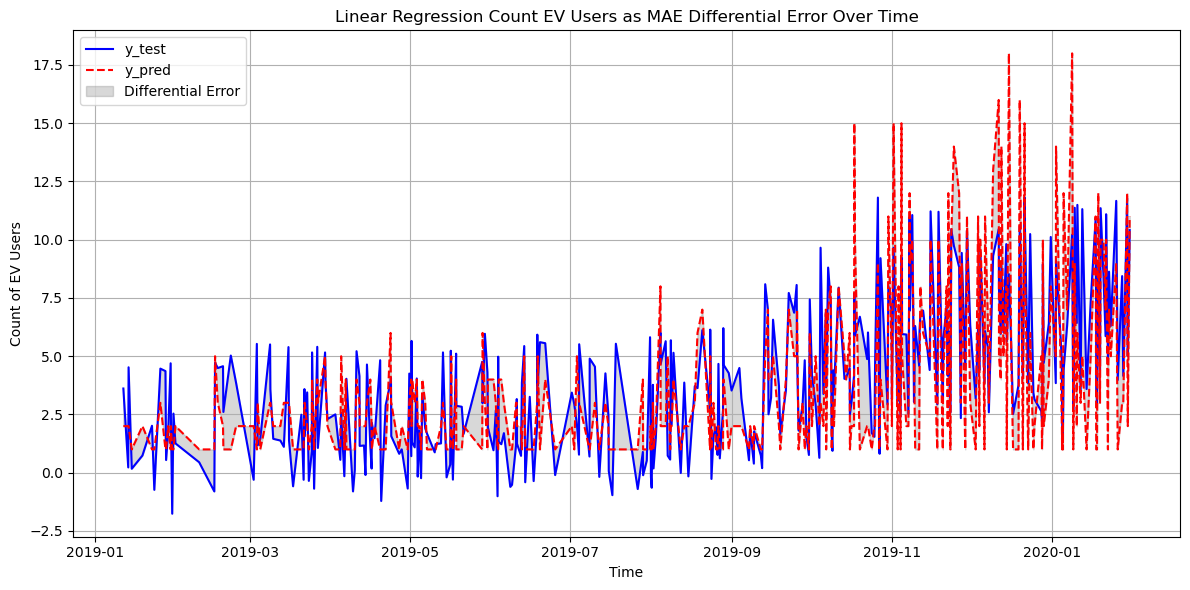

In [145]:
# Plot results across time 
plt.figure(figsize=(12, 6))
time = X_test_date
y_pred_series = pd.Series(y_pred, index=X_test_date["Date"])

time = time.sort_index()
y_test_sort = (y_pred_series.sort_index())
y_pred_series_sort = (y_test.sort_index())

plt.plot(y_test_sort, label='y_test', color='blue', linestyle='-') # time,
plt.plot(y_pred_series_sort, label='y_pred', color='red', linestyle='--') # time,

plt.fill_between(y_test_sort.index, y_test_sort, y_pred_series_sort, color='gray', alpha=0.3, label='Differential Error') # time,

plt.xlabel('Time')
plt.ylabel('Count of EV Users')
plt.title('Linear Regression Count EV Users as MAE Differential Error Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [146]:

# Linear Regression to predict the count of users in a 3 hour charging time window

# update : 'prev_3hr_count_users', 'trail_7_days_net_kWh_sum' , 'prev_net_El_kWh_daily_sum' , 'prev_3hr_count_users' , 'prev_3hr_P_c_avg_5_point_traffic_avg' , 'prev_3hr_net_El_kWh'
X = merged_df_weekly_caps[['prev_3hr_count_users', 'trail_7_days_net_kWh_sum' , 'prev_net_El_kWh_daily_sum' , 'prev_3hr_count_users' , 'prev_3hr_P_c_avg_5_point_traffic_avg' , 'prev_3hr_net_El_kWh', 'Plugin_category']]  

# update : net_El_kWh
y = merged_df_weekly_caps['net_El_kWh']  

X = pd.get_dummies(X, columns=['Plugin_category'], drop_first=True)
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# print(y_pred)

In [148]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

print("Model Score accuracy: Train data", model.score(X_train,y_train))
print("Model Score accuracy: Test data", model.score(X_test,y_test))

R-squared: 0.4369270514133825
Mean Squared Error: 1533.7651647621437
Mean Absolute Error: 29.22264770263941
Model Score accuracy: Train data 0.4753960755755072
Model Score accuracy: Test data 0.4369270514133825


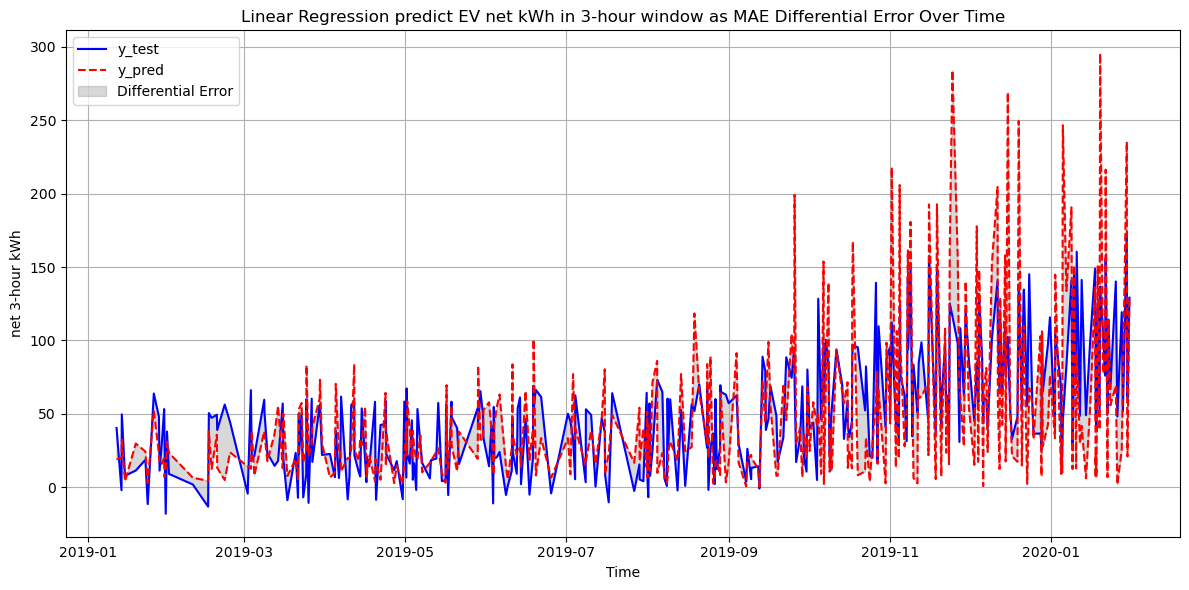

In [149]:
# Plot results across time 
plt.figure(figsize=(12, 6))
time = X_test_date
y_pred_series = pd.Series(y_pred, index=X_test_date["Date"])

time = time.sort_index()
y_test_sort = (y_pred_series.sort_index())
y_pred_series_sort = (y_test.sort_index())

plt.plot(y_test_sort, label='y_test', color='blue', linestyle='-') # time,
plt.plot(y_pred_series_sort, label='y_pred', color='red', linestyle='--') # time,

plt.fill_between(y_test_sort.index, y_test_sort, y_pred_series_sort, color='gray', alpha=0.3, label='Differential Error') # time,

plt.xlabel('Time')
plt.ylabel('net 3-hour kWh')
plt.title('Linear Regression predict EV net kWh in 3-hour window as MAE Differential Error Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

## Discussion & Conclusion

Here we performed EDA and applied supervised machine learning method Linear regression to the dataset of EV charging data. It appears that the data features did not have strong trends correlating the exact quantity of electricity charged to times of use, months of use, surrounding street traffic levels, or trailing 7-day windows of previous usage. 

We did find that the count of users, both private and public "shared" users, demonstrated moderate correlation to the trailing 7-day window of average, total, and maximum net electric usage of all EV chargers. The count of users also shows correlation to the surrounding traffic levels, and the 3-hour time window of use. On a total net annual level, for the provided data we see about a 40% accurate prediction of the precise number of users for the EV chargers, based on the time window, traffic, and trailing usage records. 

While these results do not provide full certainty, they do represent useful information in forecasting periods of demand surge and denial. A building manager could use this information to advise residents of possible surges in demand so as to avoid limiting access; they could likewise take precautions to privatize the infrastructure preemptively at key times to ensure residents have access to EV charging.

Further, we see the mean absolute error is only about 2.3, meaning that the estimated count of users for a given time window would likely be accurate to +/- 2 people on average. Even though the precise count of users was only correct 40% of the time in the training data set, being able to predict the number of users accessing EV charging infrastructure within 2 people on average is useful.  

We can note how the majority of the y predicted values for both Linear Regression models show more significant deviation from the actual values during the later periods in time, roughly from October through January. This indicates that while fairly accurate, the models have been overfit on the data from the early portion of the year. Based on analysis of the net energy draw throughout the span of collected data, we see this increase through time. The cause of this observation may be increased user knowledge of the infrastructure, additional infrastructure added, or increase net user demand regionally. These factors would cause a paradigm shift from the early part of the data versus the later. Future models might take this into account, or include additional data for a more balanced depiction of usage demands. Simply put, the model became too sensitive to the input features, causing dramatic spikes in predicted output. 